In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.path import Path
import tskit as tsk
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d


from bgspy.utils import bin_chrom, bin_chroms, read_centro
from bgspy.plots import get_figax

from bgspy.theory2 import Q2_asymptotic, Q2_sum_integral, Q2_sum_integral2
from bgspy.theory2 import ave_het, bgs_segment_sc16_vec, bgs_segment_sc16
from bgspy.theory2 import bgs_rec
from bgspy.theory2 import bgs_segment_sc16_parts
from bgspy.theory2 import Ne_t, Ne_asymp2, Ne_asymp
from bgspy.theory2 import Qr_asymp, Qr_asymp2
from bgspy.theory2 import Qr_fixed, Qr_fixed2
from bgspy.theory2 import Ne_t_full2

In [3]:
# there appears to be a bug in matplotlib where the rcParams
# are only not ignored if I call plt.show() first...
plt.show()

In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [5]:
mpl.__version__, plt.rcParams['figure.dpi'], plt.rcParams['figure.figsize']

('3.7.1', 200.0, [8.0, 4.0])

In [6]:
# fixed params from the sims
L = 100_000
N = 1_000
rbp = 1e-8

## Data

### Input Data

 - `../slim_sims/region/runs/region/N__1000/mu__1e-08/sh__0.001/rbp__1e-08/`: a directory of tree results to show diversity over chromosome.
 
 - `../slim_sims/region/region_results.pkl`: process region simulation results
 
 
### Created Data

 - `../data/supplementary_data/region_simulation_data.tsv.gz', sep='\t', index=False)`: regional simulation data, with revised ratchet rates
 - `../data/supplementary_data/simulation_ratchet_data.tsv.gz', sep='\t', index=False)`: ratchet dataframe.
 - `../data/supplementary_data/region_theory_data.pkl`: predicted theory for the regional simulation comparison.

# Region Simulations

## Diversity along the chromosome in region simulations

When comparing theory to simulations, we must be mindful that the theory is modeling the reduction *at the middle of the chromosome*. We can see why this is important by taking a subset of the tree sequences from simulations with the same parameters and looking at windowed average diversity: 

In [7]:
tree_dir = '../slim_sims/region/runs/region/N__1000/mu__1e-08/sh__0.001/rbp__1e-08/'
tree_files = [f for f in os.listdir(tree_dir) if f.endswith('.tree')]

bins = bin_chrom(L, 1000)

pi = [tsk.load(os.path.join(tree_dir, f)).diversity(windows=bins, mode='branch') for f in tree_files]

Text(0.5, 0, 'position')

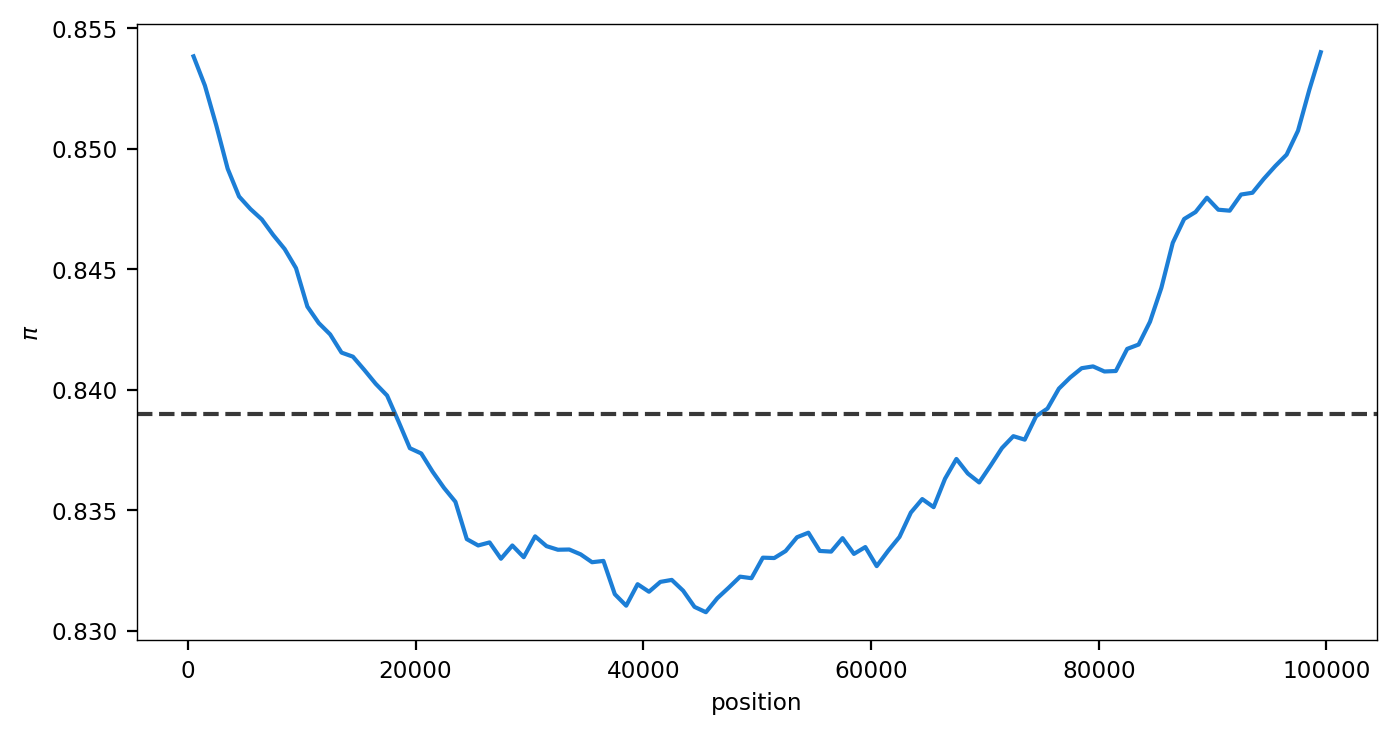

In [8]:
midpoints = (bins[1:] + bins[:-1])/2
plt.plot(midpoints, np.stack(pi).mean(axis=0)/(4*N))
plt.axhline(np.mean(pi)/(4*N), c='0.22', linestyle='dashed')
plt.ylabel("$\pi$")
plt.xlabel("position")

## Load in Simulation Results

Pre-processed by `tools/process_region_sims.py`.

NOTE: the ratchet estimates here in these data are wrong (and these take a while to run), so I correcth them below.

In [9]:
d = pd.read_pickle('../slim_sims/region/region_results.pkl')
d.head()

,cycle,k_mean,k_sd,k3,k4,f_mean,f_sd,f3,f4,s,...,B_middle,ratchet,sh,N,rbp,mu,U,r2sum,ldsum,ldn
0,9991,0.134,0.360797,0.121316,0.152642,0.999577,0.001140,-3.825070e-09,1.519620e-11,0,...,0.760940,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.054063,0.004012,5
1,9991,0.184,0.395348,0.109579,0.112485,0.999419,0.001249,-3.456770e-09,1.120880e-11,0,...,1.224619,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.001276,-0.001210,4
2,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,1.390866,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.000000,0.000000,0
3,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,1.044498,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.000000,0.000000,0
4,9991,0.330,0.537949,0.211854,0.325596,0.998957,0.001700,-6.684950e-09,3.246590e-11,0,...,0.851810,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.000000,0.000000,0


In [37]:
d.columns

Index(['cycle', 'k_mean', 'k_sd', 'k3', 'k4', 'f_mean', 'f_sd', 'f3', 'f4',
       's', 'r', 'ssh', 'R', 'B', 'B_middle', 'ratchet', 'sh', 'N', 'rbp',
       'mu', 'U', 'r2sum', 'ldsum', 'ldn'],
      dtype='object')

### Ratchet Rate Correction

Note that the ratchet estimates by my processing program are biased, because I didn't trim off enough burnin. So I re-restimate those here (before the data is saved for supp data).

In [10]:
def average_ratchet_rates(d):
    data = dict()
    for mu in d['mu'].unique():
        for sh in d['sh'].unique():
            # get the ratchet values
            M = d.loc[(d['sh'] == sh) & (d['mu'] == mu)]['ratchet'].values
            D = np.stack([x for x in M]) 
            D_mean = D.mean(axis=0)
            data[(mu, sh)] = D_mean
    return data
    
def ratchet_rate_estimate(data, buffer=9000):
    rates = dict()
    for mu, sh in data.keys():
        d = data[(mu, sh)]
        if buffer is not None:
            d = d[d[:, 0] > buffer, :]
        X = sm.add_constant(d[:, 0])
        y = d[:, 1]
        fit = sm.OLS(y, X).fit()
        R = fit.params[1]
        rates[(mu, sh)] = R
    return rates
    

rate_data = average_ratchet_rates(d)
rates = ratchet_rate_estimate(rate_data)

In [11]:
# let's make a friendlier dataframe of these data

rows = []
for key in rate_data.keys():
    mu, sh = key
    for row in rate_data[key]:
        rows.append(dict(mu=mu, sh=sh, generation=row[0], fixations=row[1], rate=rates[key]))
ratchet_df = pd.DataFrame(rows)


In [12]:
d['mu'].unique()

array([1.00e-09, 3.16e-10, 3.16e-09, 1.00e-08])

In [13]:
rate_data.keys()

dict_keys([(1e-09, 0.00316), (1e-09, 0.1), (1e-09, 0.0001), (1e-09, 3.16e-05), (1e-09, 0.01), (1e-09, 0.000316), (1e-09, 0.0316), (1e-09, 0.001), (3.16e-10, 0.00316), (3.16e-10, 0.1), (3.16e-10, 0.0001), (3.16e-10, 3.16e-05), (3.16e-10, 0.01), (3.16e-10, 0.000316), (3.16e-10, 0.0316), (3.16e-10, 0.001), (3.16e-09, 0.00316), (3.16e-09, 0.1), (3.16e-09, 0.0001), (3.16e-09, 3.16e-05), (3.16e-09, 0.01), (3.16e-09, 0.000316), (3.16e-09, 0.0316), (3.16e-09, 0.001), (1e-08, 0.00316), (1e-08, 0.1), (1e-08, 0.0001), (1e-08, 3.16e-05), (1e-08, 0.01), (1e-08, 0.000316), (1e-08, 0.0316), (1e-08, 0.001)])

Text(0.5, 0, 'generation')

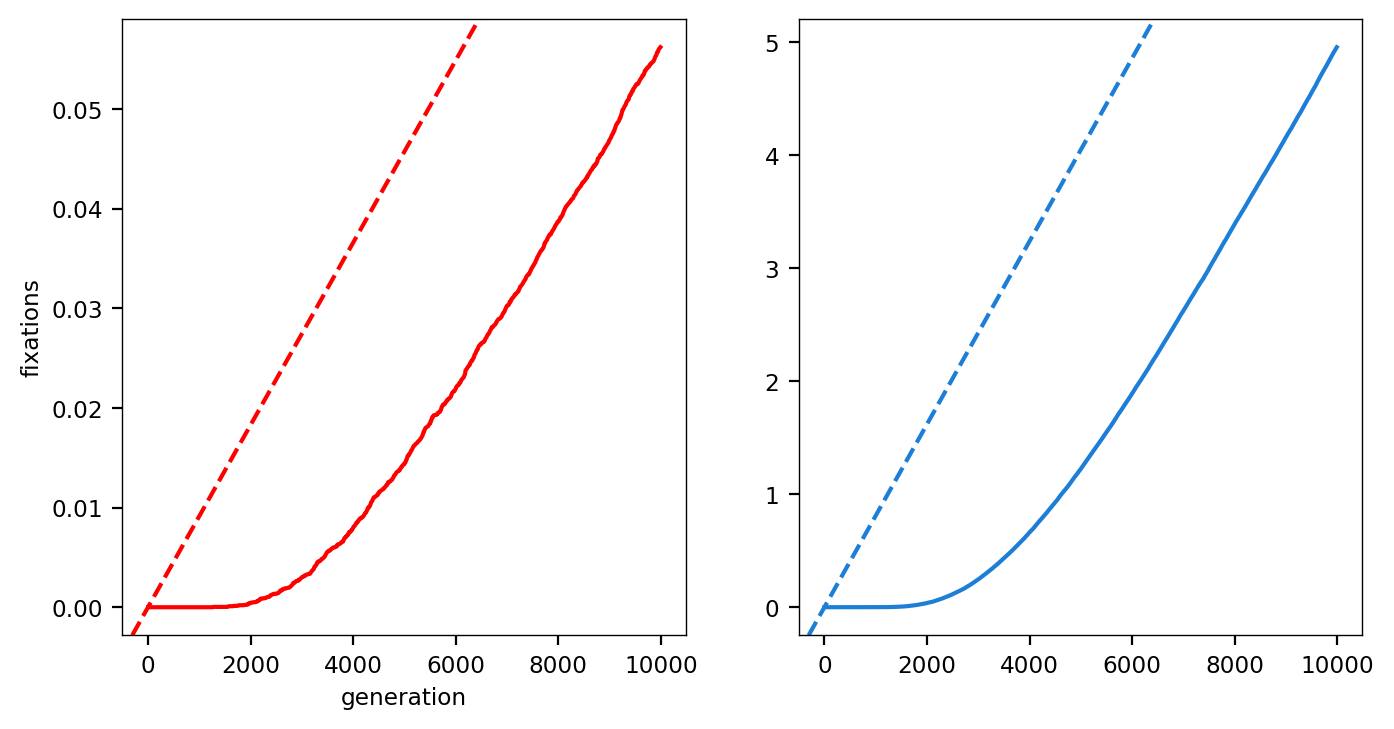

In [14]:
key_1, key_2 = (1e-09, 0.001), (1e-08, 0.0001)

fig, ax = plt.subplots(ncols=2)
ax[0].plot(*rate_data[key_1].T, c='r', label='μ = 1e-8, s=1e-5')
ax[0].axline((0, 0), slope=rates[key_1], c='r', linestyle='dashed')
ax[1].plot(*rate_data[key_2].T, label='μ = 1e-8, s=1e-3')
ax[1].axline((0, 0), slope=rates[key_2], linestyle='dashed')
ax[0].set_ylabel('fixations')
ax[0].set_xlabel('generation')
#plt.semilogy()
#ax[0].legend()

This shows that rates hit equilibria after ~4N generations.

### Save Supplementary Data

In [15]:
# let's make a friendly version of the data for saving to TSV
df = d.loc[:, ~d.columns.isin(['ratchet', 'R'])]
df.to_csv('../data/supplementary_data/region_simulation_data.tsv.gz', sep='\t', index=False)

# save the ratchet data
ratchet_df.to_csv('../data/supplementary_data/simulation_ratchet_data.tsv.gz', sep='\t', index=False)

In [16]:
d.loc[(d['mu'] == 1e-8) & (d['sh'] == 0.01)]['mu']

449930    1.000000e-08
449931    1.000000e-08
449932    1.000000e-08
449933    1.000000e-08
449934    1.000000e-08
              ...     
479917    1.000000e-08
479918    1.000000e-08
479919    1.000000e-08
479920    1.000000e-08
479921    1.000000e-08
Name: mu, Length: 29992, dtype: float64

In [17]:
# average across replicates
dg = d.groupby(['sh', 'rbp', 'N', 'mu', 'U']).mean().reset_index()

/tmp/ipykernel_26438/1740891089.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dg = d.groupby(['sh', 'rbp', 'N', 'mu', 'U']).mean().reset_index()


In [18]:
dg['sh'].unique(), dg['mu'].unique(), dg['rbp'].unique()

(array([3.16e-05, 1.00e-04, 3.16e-04, 1.00e-03, 3.16e-03, 1.00e-02,
        3.16e-02, 1.00e-01]),
 array([3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]),
 array([1.e-08]))

# Comparing Simulations to Theory

Pre-compute all the theory data, for the regional simulations.

In [ ]:
theory_data = dict()

x = np.logspace(-5, 1, 100)
for mu in dg['mu'].unique():
    # NOTE: we need asymptotic = False so that *everything* is computed (which is more expensive)
    parts = np.array(bgs_segment_sc16_parts(mu, x, L, rbp, N, asymptotic=False))
    Bs = np.array([x[0] for x in parts])
    Bs_asymp = np.array([x[1] for x in parts])
    other_stuff = [x[5:] for x in parts]
    classic_bgs = np.array([x[-1] for x in parts])
    Vs = np.array([x[3] for x in parts])
    Vms = np.array([x[4] for x in parts])    
    Ts = np.array([x[2] for x in parts])
    theory_data[mu] = x, Bs, Bs_asymp, Vs, Ts, classic_bgs, other_stuff
    

/home/vsb/projects/bprime/bgspy/theory2.py:92: RuntimeWarning: overflow encountered in exp
  out = (np.exp(4*sh*Ne) - 1)/(2*U*sh*Ne)
/home/vsb/projects/bprime/bgspy/theory2.py:326: RuntimeWarning: invalid value encountered in scalar subtract
  return [np.log(new_T) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory2.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrand = quad(lambda r: ((1-(1-r)**(T+1) * Z**(T+1))/(1 - (1-r)*Z))**2, 0, M/2)[0]
/home/vsb/projects/bprime/bgspy/theory2.py:122: RuntimeWarning: overflow encountered in scalar power
  integrand = quad(lambda r

In [ ]:
# save the region predictions from theory 
with open('../data/supplementary_data/region_theory_data.pkl', 'wb') as f:
    pickle.dump(theory_data, f)

## Main Region Simulation Figures

### Figure 1A

(0.0015, 100)


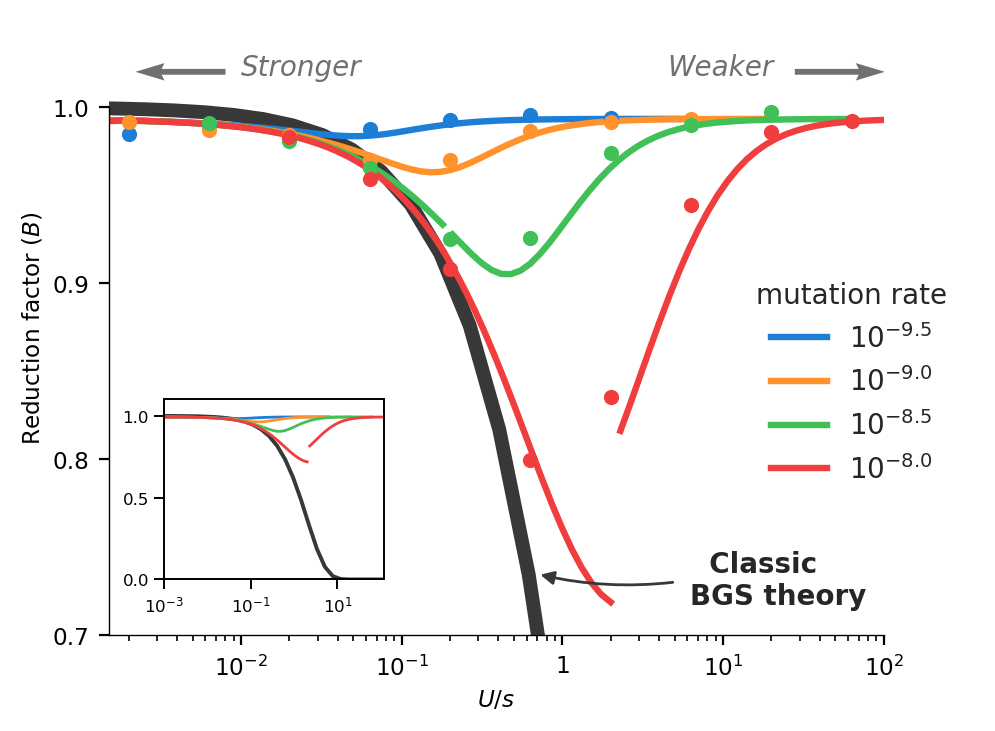

In [281]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker


def log10_formatter(x, pos):
    if x == 1.0:
        return '1'
    else:
        return '$10^{%d}$' % np.log10(x)


def B_theory_plot(sim_dg, L, rbp, N, mus=None, x=np.logspace(-5, np.log10(0.9), 50), 
                  include_asymp=True, labels=True, xlim=None, ylim=None, 
                  marker_size=5, linewidth=2, data=None,
                  bgs_linewidth=2, bgs_zorder=10, figax=None, **figax_kwargs):
    fig, ax = get_figax(figax, **figax_kwargs)
    if mus is None:
        mus = sim_dg['mu'].unique()
    for mu in mus:
        dgs = sim_dg.loc[dg['mu'] == mu]

        U = 2*mu*L
        mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
        
        # sim data
        sh = dgs['sh'].values
        rate = U/sh
        col = next(ax._get_lines.prop_cycler)['color']
        #ax.scatter(rate, dgs['B_middle'], edgecolor='white', linewidth=0.2, c=col, s=marker_size, zorder=10)
        ax.scatter(rate, dgs['B_middle'], edgecolor='white', linewidth=0, c=col, s=marker_size, zorder=10)

        # theory part
        if data is None:
            # calculate the values directly
            Bs_asymp = np.array(bgs_segment_sc16_vec(mu, x, L, rbp, N, dont_fallback=False))
            Bs = np.array(bgs_segment_sc16_vec(mu, x, L, rbp, N, dont_fallback=False, asymptotic=False, sum_n=10))
        else:
            if mu not in data:
                continue
            # use pre-calc'd dict
            x, Bs, Bs_asymp, Vs, Ts, classic_bgs, other_stuff = data[mu]
        #Bs = np.array(bgs_segment_sc162(mu, x2, L, rbp, 1000, asymptotic=False, sum_n=10))
        #plt.plot(U/x, Bs_asymp, label=mu)

        if include_asymp:
            ax.plot(U/x, Bs_asymp, c=col, linestyle='dashed', linewidth=linewidth)
        #ax.plot(U/x, Bs, c=col, linewidth=linewidth, label=mu_label)
        ax.plot(U/x[~classic_bgs], Bs[~classic_bgs], c=col, linewidth=linewidth, label=mu_label)
        #ax.plot(U/x[classic_bgs], Bs[classic_bgs], c=col, linestyle=(0, (7, 2)), linewidth=linewidth)
        ax.plot(U/x[classic_bgs], Bs[classic_bgs], c=col, linewidth=linewidth)
    mu = max(mus)
    mu_x = np.logspace(-8, 1, 50)
    bgs_theory = bgs_rec(mu, mu_x, L, rbp)
    ax.plot(2*mu*L/mu_x, bgs_theory, c='0.22', linewidth=bgs_linewidth, zorder=bgs_zorder)
    #ax.yaxis.grid(linestyle='dashed') 

    ax.semilogx()
    if labels:
        ax.set_ylabel("B")
        ax.set_xlabel("U/s")
    if ylim is not None:
        ax.set_ylim(*ylim)
    if xlim is not None:
        print(xlim)
        ax.set_xlim(*xlim)
    else:
        ax.set_xlim(1e-3, 120)
    return fig, ax
    

plt.rcParams['text.usetex'] = False

    
fig, ax = plt.subplots(figsize=(5, 4))

axin = inset_axes(ax, width=1.1, height=0.9, loc=3, borderpad=2)

MUs = [3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]

## MAIN CALLS
B_theory_plot(dg, L=L, rbp=rbp, N=N,
              mus=MUs,
              figax=(fig, ax), data=theory_data,
              xlim=(0.0015, 100), include_asymp=False,
              #ylim=(0.70, 1.005), 
              ylim=(0.70, 1.05), 
              marker_size=30, bgs_zorder=1,
              legend=True, bgs_linewidth=5, linewidth=2.3)
B_theory_plot(dg, L=L, rbp=rbp, N=N, 
              mus=MUs,
              figax=(fig, axin), data=theory_data,
              ylim=(0, 1.1), include_asymp=False, 
              legend=False, labels=False, bgs_zorder=-1, marker_size=0,
              bgs_linewidth=1.4, linewidth=1)


for item in ([axin.title, axin.xaxis.label, axin.yaxis.label] +
              axin.get_xticklabels() + axin.get_yticklabels()):
    item.set_fontsize(6)

axin.tick_params(axis="y", direction="out", pad=2)
axin.tick_params(axis="x", direction="out", pad=2)
axin_axeswidth = 0.7
for spine in ['top', 'right', 'left', 'bottom']:
    axin.spines[spine].set_visible(True)
    axin.spines[spine].set_linewidth(axin_axeswidth)
axin.xaxis.set_tick_params(width=axin_axeswidth)
axin.yaxis.set_tick_params(width=axin_axeswidth)
    
# draw the box around zoomed-in region
draw_box = False
if draw_box:
    x, y = ax.axes.get_xlim(), ax.axes.get_ylim()
    zoom = mpl.patches.Rectangle((x[0], y[0]), x[1] - x[0], y[1] - y[0], 
                                 linewidth=0.1, edgecolor='0.22', facecolor='none')
    axin.add_patch(zoom)

#ax.axhline(1, linestyle='dashed', c='0.22', linewidth=1, zorder=-1)
#axin.axhline(1, linestyle='dashed', c='0.22', linewidth=0.5, zorder=-1)

leg = ax.legend(loc=(0.8, 0.2), fontsize=10, title="mutation rate", framealpha=1, facecolor='white')
frame = leg.get_frame()
frame.set_facecolor('blue')
arrowlab_y = 1.018
ax.text(0.01, arrowlab_y, "Stronger", c='0.44', style='italic')
ax.quiver(0.008, 1.02, -0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.text(4.5, arrowlab_y, "Weaker",  c='0.44', style='italic')
ax.quiver(28, 1.02, 0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.annotate("  Classic\nBGS theory", xy=(0.55, 0.1), xytext=(0.75, 0.05), 
            backgroundcolor='white', 
             arrowprops=dict(arrowstyle="-|>", color='0.22', relpos=(0., 0.5),
                            connectionstyle="arc3,rad=-0.1"),
            xycoords=ax.transAxes, weight=550)

ax.set_ylabel("Reduction factor ($B$)")
ax.set_xlabel("$U/s$")
ax.spines['left'].set_bounds((0.7, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.grid(linestyle='dashed')
ax.set_axisbelow(True)
#axin.annotate("  Classic\nBGS theory", xy=(0.05, 0.1), fontsize=5)
ax.set_yticks([0.7, 0.8, 0.9, 1])

# mask the grid behind arrows
mask_grid_quiver = mpl.patches.Rectangle((0, 1.005), 100, 0.1, facecolor='white', zorder=1)
ax.add_patch(mask_grid_quiver)

# mask grid behind legend
mask_grid = mpl.patches.Rectangle((15, 0.2), 400, 0.8, facecolor='white', zorder=1)
ax.add_patch(mask_grid)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))

plt.savefig('../manuscript/figures/figure_1A.pdf', bbox_inches='tight')

### Figure 1B

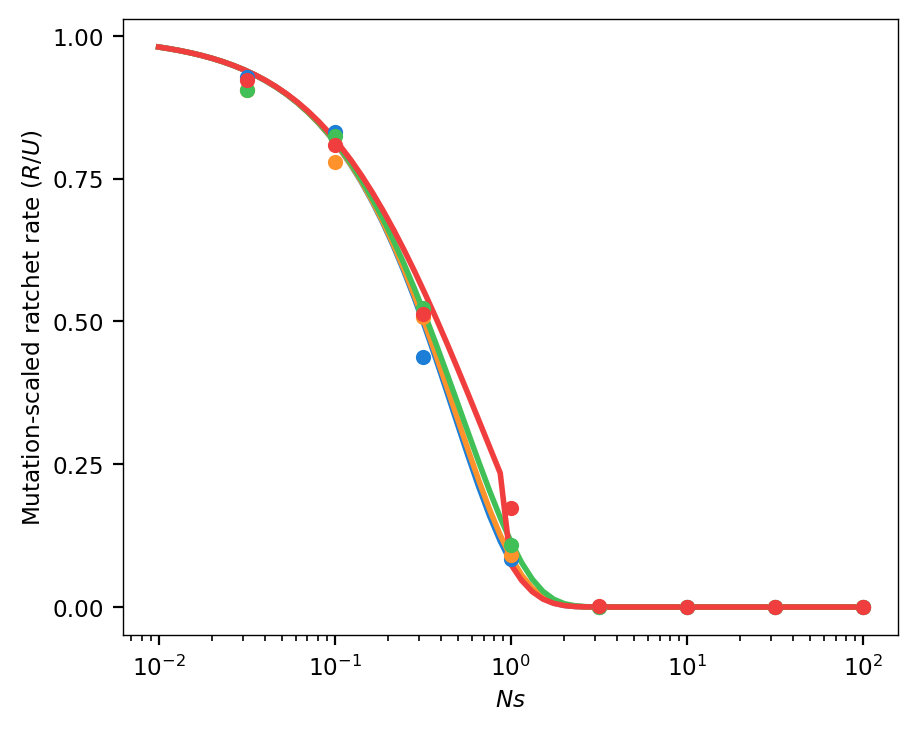

In [54]:
def ratchet_plot(theory_data, figsize=(5, 4), figax=None, marker_size=20,
                 ylabel="Mutation-scaled ratchet rate ($R/U$)", xlabel="$Ns$",
                 **figax_kwargs):
    fig, ax = get_figax(figax, **figax_kwargs)
    for mu in theory_data.keys():
        mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
        dgs = dg.loc[dg['mu'] == mu]
        U = 2*mu*L
        s = theory_data[mu][0]
        sN = s*N
        T = theory_data[mu][4]
        R = 2/(T*U)
        col = next(ax._get_lines.prop_cycler)['color']
        keep = sN < 1e2
        ax.plot(N*s[keep], R[keep], c=col, alpha=1, linewidth=2, label=mu_label)

        R_est = np.array([rates[(mu, sh)] for sh in dgs['sh']])
        ax.scatter(dgs['sh']*N, 2*R_est/U, c=col, s=marker_size, zorder=10)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.yaxis.set_ticks([0,0.25, 0.5, 0.75, 1])

    #ax.legend(title="mutation rate")
    #ax.axhline(1, linestyle='dashed', c='0.22')
    #ax.grid(linestyle='dashed')
    #ax.annotate("neutral fixation rate ($R = U$)", (1, 1.01), xycoords='data')
    ax.set_xscale('log')
    #ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')
    return fig, ax

fig, ax = plt.subplots(figsize=(5, 4))
ratchet_plot(theory_data, figax=(fig, ax))

plt.savefig('../manuscript/figures/figure_1B.pdf', bbox_inches='tight')

### Figure 1C

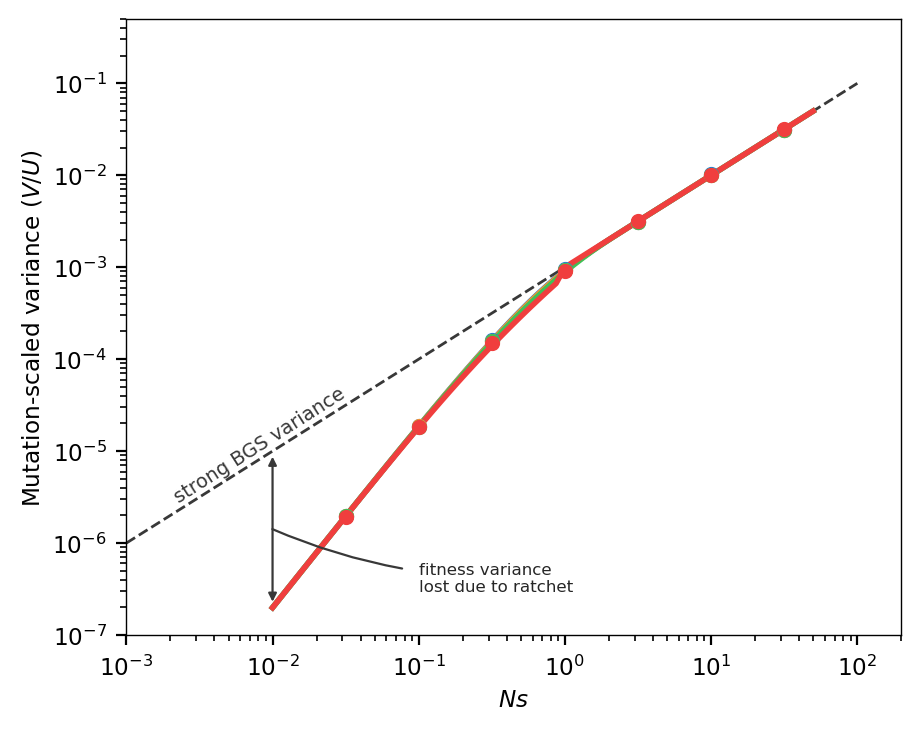

In [277]:
def variance_plot(theory_data, figsize=(5, 4), 
                  ylabel="Mutation-scaled variance ($V/U$)", xlabel="$Ns$", marker_size=20,
                  figax=None, **figax_kwargs):
    fig, ax = get_figax(figax, **figax_kwargs)
    # NOTE we truncate the x axis -- just for visual apperance. The fit here is perfect (classic BGS)
    xend = 50
    for mu in theory_data.keys():
        mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
        U = 2*mu*L
        sN = theory_data[mu][0] * N
        T = theory_data[mu][4]
        V = theory_data[mu][3] / U
        R =  1/T
        

        keep = sN < xend
        col = next(ax._get_lines.prop_cycler)['color']
        ax.plot(sN[keep], V[keep], linewidth=2,  label=mu_label, c=col)

        # new theory
        dgs = dg.loc[dg['mu'] == mu]
        dgs_alt = dgs.loc[dgs['sh'] * N < xend, :] # trim to end
        
        #Va = dgs_alt['f_sd']**2 # this is the pop fitness across indiduals (+LD)
        Va = dgs_alt['sh']**2 * dgs_alt['ssh'] /2 # genic Va
        ax.scatter(dgs_alt['sh'] * N, Va / (dgs_alt['U']), c=col, s=marker_size, zorder=10)
    xs = np.logspace(-6, -1, 100)
    #keep = xs < xend
    ax.plot((xs*N), xs, zorder=-10, linestyle='dashed', c='0.22', linewidth=1)
    #ax.annotate("strong BGS variance", (2e-3, 4e-6), xycoords='data', rotation=30)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    #ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')
    #fig.canvas.draw()
    #ax.legend(loc=(-0.04, 0.6), fontsize=10, ncol=2, title="mutation rate")
    ax.loglog()
    ax.set_xlim(1e-3, 2e2)
    ax.set_ylim(1e-7, 0.5)
    #ax.annotate("$Ns = 1$", (1.1, 5e-8), xycoords='data', weight=550)
    #ax.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7),
    #            xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>'))
    #ax.annotate("fitness variance\nlost due to ratchet", (6e-3, 3e-7), horizontalalignment='center',
    #            bbox=dict(facecolor='white', alpha=1, linewidth=0), 
    #            fontsize=6, rotation=30)
    return fig, ax

fig, ax = plt.subplots(figsize=(5, 4))
variance_plot(theory_data, figax=(fig, ax))
ax.annotate("strong BGS variance", (2e-3, 2.8e-6), xycoords='data', rotation=32.5, color='0.22', fontsize=7)

fig.canvas.draw()
ax.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7), fontsize=6,
            xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>', linewidth=0.8), zorder=20)

ax.annotate("fitness variance\nlost due to ratchet", xy=(9.2e-3, 1.5e-6), xytext=(1e-1, 3e-7), horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=1, linewidth=0), 
            arrowprops=dict(color='0.22', connectionstyle="arc3,rad=-0.1", arrowstyle='-', linewidth=0.8),
            fontsize=6, rotation=0)

plt.savefig('../manuscript/figures/figure_1C.pdf', bbox_inches='tight')

## OLD

In [ ]:
def rel_error_plot(mse_df, marker_size=5, linewidth=0.8, figax=None):
    fig, ax = get_figax(figax)
    labs = set()
    for w in mse_df['w']:
        if w > 1e-8 or w == 1e-10:
            continue    
        mse_dfx = mse_df.loc[mse_df['w'] == w, :]
        expon = np.round(np.log10(w), 2)
        expon = int(expon) if int(expon) == expon else expon
        lab_text = f"$10^{{{expon}}}$"
        lab = None if lab_text in labs else lab_text
        lines = ax.plot(mse_dfx.t, 100*mse_dfx.bp_relerror, linewidth=linewidth, label=lab, marker='o', markersize=marker_size)
        labs.add(lab_text)
        #ax.scatter(mse_dfx.t, 100*mse_dfx.bp_relerror, c=lines[0].get_color(), s=marker_size, zorder=10)

        ax.plot(mse_dfx.t, 100*mse_dfx.b_relerror, linestyle='dashed',
                linewidth=linewidth,
                c=lines[0].get_color(), marker='o', markersize=marker_size)
        #ax.scatter(mse_dfx.t, 100*mse_dfx.b_relerror, c=lines[0].get_color(), s=marker_size, zorder=10)
    ax.loglog()
    #ax.semilogx()
    ax.set_ylim(0, 100)
    #ax.set_xlim(1e-7, 1.1e-1)
    #ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    #ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    ax.set_yticklabels(('10%', '100%'))
    ax.set_yticks((10, 100))
    ax.set_ylabel("relative error")
    ax.set_xlabel("selection coefficient")

In [ ]:
def split_chrom_ax(ax, rec_x, rec_y, gen_x, gen_y, rec_quantile=(0.01, 0.95), gen_quantile=(0.01, 0.99)):
    bar_height = 10
    rec_ax, gen_ax = ax
    rate_min, rate_max = np.nanquantile(rec_y, rec_quantile[0]), np.nanquantile(rec_y, rec_quantile[1])

    rec_y[np.isnan(rec_y)] = np.nanmin(rec_y)
    smooth_rec_y = gaussian_filter1d(rec_y, 2)

    rec_norm = plt.Normalize(rate_min, rate_max)
    rec_cbar = rec_ax.pcolor(rec_x, np.arange(bar_height), np.repeat(smooth_rec_y[:, None], bar_height, axis=1).T, 
                             norm=rec_norm, cmap='viridis', alpha=1, snap=True, linewidth=0, rasterized=True)


    gen_norm = plt.Normalize(np.nanquantile(density, gen_quantile[0]), np.nanquantile(density, gen_quantile[1]))
    smooth_gen_y = gaussian_filter1d(density, 2)
    gen_cbar = gen_ax.pcolor(gen_x, np.arange(bar_height), np.repeat(smooth_gen_y[:, None], bar_height, axis=1).T, 
                             norm=gen_norm, cmap='plasma', 
                             # the follow options get rid of those nasty lines in PDF
                             alpha=1, snap=True, linewidth=0, rasterized=True)

    return rec_cbar, gen_cbar

In [ ]:
mse_df = pd.read_csv('../data/supplementary_data/theory_simulation_comparison.tsv', delimiter='\t')

In [ ]:
mse_df.head()

In [ ]:
# load in subfigure D data
with open('../data/supplementary_data/figure_1_bmap_data.pkl', 'rb') as f:
    sibfigc_data = pickle.load(f)
    


g = sibfigc_data['g']
b = sibfigc_data['b']
bp = sibfigc_data['bp']
bp_rs = sibfigc_data['bp_rs']
m = sibfigc_data['m']
sim_means_100kb = sibfigc_data['sim_means_100kb']
sim_sd_100kb = sibfigc_data['sim_sd_100kb']

In [ ]:
## do some processing for the recombination/gene density track

WIDTH = 100_000

i = np.zeros(g.seqlens['chr10'])
for row in m.segments.ranges:
    i[slice(*row)] = 1

covered_bases = np.where(i)[0]
wins = np.linspace(0, g.seqlens['chr10'], g.seqlens['chr10'] // WIDTH).astype(int)

# compute the coverage by binning covered bases and summing up indicator variables where they are
coverage = stats.binned_statistic(covered_bases, np.full(len(covered_bases), 1), statistic=np.sum, bins=wins)

In [ ]:
# get the coverage stats end positions out
width = (coverage.bin_edges[1:] - coverage.bin_edges[:-1])
density_midpoints, density = (coverage.bin_edges[1:] + coverage.bin_edges[:-1])/2, 100*coverage.statistic/width

In [ ]:
density_midpoints.shape, density.shape

In [ ]:
rec_ends, rec_rates = m.recmap.rates['chr10']

REC_WIDTH = 100_000
rec_wins = np.linspace(0, g.seqlens['chr10'], g.seqlens['chr10'] // REC_WIDTH).astype(int)

bin_rec = True

if bin_rec:
    rec_bins = stats.binned_statistic(rec_ends, rec_rates, statistic=np.nanmean, bins=rec_wins)
    rec_bin_rates = rec_bins.statistic
    rec_bin_midpoints = 0.5*(rec_bins.bin_edges[1:] + rec_bins.bin_edges[:-1])
else:
    rec_bin_rates = rec_rates
    rec_bin_midpoints = rec_ends
    
#rec_bin_rates[rec_bin_rates < 0] = np.nan
#rec_bin_rates = (rec_bin_rates - np.nanmean(rec_bin_rates)) / np.nanstd(rec_bin_rates)

In [ ]:
rec_ends.shape, rec_rates.shape

In [ ]:

def centro_notch(ax, coords, seqlen, c=2.5, lw=0.5, lc='0.22', flip=False):
    ymin, ymax = ax.get_ylim()
    m = 1/c if not flip else 1-1/c
    ymid = (ymin + ymax)*m
    if flip:
        ymin, ymax = ymax, ymin
    start, cent, end = coords
    verts = [(start, ymax*1.11), (cent, ymid), (end, ymax*1.11)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    centro_verts = mpath.Path(verts, codes)
    centro_marker = patches.PathPatch(centro_verts, facecolor='white', lw=0)
    ax.add_patch(centro_marker)
    ax.plot([0, 0, start, cent, end, seqlen, seqlen], [ymin, ymax, ymax, ymid, ymax, ymax, ymin], c=lc, linewidth=lw)

centro = read_centro("../data/annotation/hg38_centro.bed")


In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(7.5, 3))
subfigs = fig.subfigures(nrows=2, ncols=1, height_ratios=[1, 1])

top_spec = subfigs[0].add_subplot()

bottom_spec = subfigs[0].add_gridspec(ncols=1, nrows=3, hspace=0, height_ratios=[1, 1, 1])


# subfig_D_spec = subfigs[1, 0].add_gridspec(ncols=1, nrows=5, hspace=0, height_ratios=[1, 0.1, 1, 0.2, 0.2])
# subfig_E = subfigs[1, 1].add_subplot()
# subfig_F = subfigs[1, 2].add_subplot()

# strong_ax = subfigs[1, 0].add_subplot(subfig_D_spec[0, 0])
# spacer_ax = subfigs[1, 0].add_subplot(subfig_D_spec[1, 0])
# weak_ax = subfigs[1, 0].add_subplot(subfig_D_spec[2, 0])
# gen_ax = subfigs[1, 0].add_subplot(subfig_D_spec[3, 0])
# rec_ax = subfigs[1, 0].add_subplot(subfig_D_spec[4, 0])

# spacer_ax.axis('off')
# rec_ax.axis('off')
# gen_ax.axis('off')

# plt.savefig('../manuscript/figures/experimental_1.pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(7.5, 3))

m = """
ABC
DEF
"""
fig.subplot_mosaic()

In [ ]:
plt.rcParams['axes.labelsize'] = 8.5
plt.rcParams['axes.labelpad'] = 3
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.linewidth'] = 0.5


fig = plt.figure(constrained_layout=True, figsize=(7.5, 3))
subfigs = fig.subfigures(nrows=3, ncols=1, height_ratios=[1, 0.05, 1], wspace=0, hspace=0)

top_row = subfigs[0].subplots(nrows=1, ncols=3, 
                              gridspec_kw={'width_ratios': [3, 2, 2], 'wspace': 0.4, 
                                           #'bottom': 0,
                                           #'left': 0., 'right':1
                                          })



mosaic = """
AFG
BFG
CFG
DFG
EFG
"""

bottom_row = subfigs[2].subplot_mosaic(mosaic,
                                       gridspec_kw={'wspace': 0., 
                                                    'width_ratios': [5, 2, 1.8], 
                                                    'height_ratios': [1, 0.1, 1, 0.2, 0.2], 
                                                    #'left': 0., 'right':1,
                                                    'hspace': 0})

strong_ax = bottom_row['A']
spacer_ax = bottom_row['B']
spacer_ax.axis('off')
weak_ax = bottom_row['C']

legend_ax = bottom_row['F']
legend_ax.axis('off')

rec_ax = bottom_row['D']
gen_ax = bottom_row['E']
rec_ax.axis('off')
gen_ax.axis('off')

relerr_ax = bottom_row['G']



###### TOP ROW 

subfig_A = top_row[0]
top_row[1].set_ylabel("test 2")

### Subfigure A


    
subfig_A_axin = subfig_A.inset_axes([0.08, 0.12, 0.35, 0.35])

B_theory_plot(dg, L=L, rbp=rbp, N=N,
              mus=MUs,
              figax=(fig, subfig_A), data=theory_data,
              xlim=(0.0015, 100), include_asymp=False,
              #ylim=(0.70, 1.005), 
              ylim=(0.70, 1.01), 
              marker_size=20, bgs_zorder=1,
              legend=True, bgs_linewidth=3, linewidth=2)
B_theory_plot(dg, L=L, rbp=rbp, N=N, 
              mus=MUs,
              figax=(fig, subfig_A_axin), data=theory_data,
              ylim=(0, 1.1), include_asymp=False, 
              legend=False, labels=False, bgs_zorder=-1, marker_size=0,
              bgs_linewidth=1.4, linewidth=1)

for item in ([subfig_A_axin.title, subfig_A_axin.xaxis.label, subfig_A_axin.yaxis.label] +
              subfig_A_axin.get_xticklabels() + subfig_A_axin.get_yticklabels()):
    item.set_fontsize(6)


###### Bottom Row


# linewidth
lwd = 0.9

# strong params
w, t = 1e-8, 3.16e-3

### Strong Selection B map
COLS = ['0.44', 'skyblue', 'orangered']
strong_ax.plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd, color=COLS[0])
strong_ax.plot(*b['chr10', w, t], label="Classic BGS", linewidth=lwd, color=COLS[1])
strong_ax.plot(*bp['chr10', w, t], label="New Theory", linestyle='dashed', linewidth=lwd, color=COLS[2])
strong_ax.set_ylim(0.5, 1.1)
#ax[0].set_xlim(10e6, g.seqlens['chr10'])

strong_ax.spines.left.set_bounds((0.5, 1))
#ax[0].spines['bottom'].set_visible(False)
strong_ax.get_xaxis().set_visible(False)
strong_ax.spines.left.set_position(("axes", -0.005)) ##############
strong_ax.spines.right.set_visible(False)
strong_ax.spines.top.set_visible(False)
strong_ax.spines.bottom.set_visible(False)


#ax[0].set_xlim(-1000000, 1.01*g.seqlens['chr10'])
#ax[1].set_xlim(-1000000, 1.01*g.seqlens['chr10'])


######## spacer between B maps

### Weak Selection B map
# weak params
w, t = 1e-8, 1e-4
mb_bins = bin_chroms(g.seqlens, 40e3)
#weak_ax.xaxis.set_major_formatter(ticks_x)
weak_ax.plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd,  color=COLS[0])
weak_ax.plot(*b.bin_means(mb_bins)['chr10', w, t], label="Classic BGS Theory", linewidth=lwd, color=COLS[1])
weak_ax.plot(*bp['chr10', w, t], label="New Theory", linewidth=lwd, color=COLS[2])
weak_ax.get_xaxis().set_visible(False)
#ax[1].axis('off')
weak_ax.spines['bottom'].set_visible(False)
weak_ax.spines['top'].set_visible(False)
weak_ax.spines['right'].set_visible(False)
weak_ax.spines.left.set_bounds((0, 1))

weak_ax.sharex(strong_ax)
rec_ax.sharex(strong_ax)
gen_ax.sharex(strong_ax)

split_chrom_ax((rec_ax, gen_ax), rec_bin_midpoints, rec_bin_rates, density_midpoints, density)

centro_notch(gen_ax, centro['chr10'], seqlen=g.seqlens['chr10'], flip=True)
centro_notch(rec_ax, centro['chr10'], seqlen=g.seqlens['chr10'])

rel_error_plot(mse_df, marker_size=2, figax=(fig, relerr_ax))
leg = relerr_ax.legend(fontsize=5, ncol=1, handlelength=1)
for lh in leg.legendHandles:
    lh.set_markersize(0)
    

        
plt.savefig('../manuscript/figures/experimental_1.pdf', bbox_inches='tight')

In [ ]:
plt.rcParams['axes.labelsize'] = 8.5
plt.rcParams['axes.labelpad'] = 3
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.linewidth'] = 0.5

#plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=["wheat", "seagreen", "indianred", "cornflowerblue"])
#plt.rcParams['axes.prop_cycle'] = mpl.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


plt.rcParams['text.usetex'] = False
label_fs = 9

fig = plt.figure(constrained_layout=False, figsize=(7.5, 3.5))
subfigs = fig.subfigures(3, 1, height_ratios=[0.5, 0.1, 0.7], wspace=0.0, hspace=0.5)
#top_row = subfigs[0].subplots(1, 4, width_ratios=[1.2, 1, 1, 0.01])
top_row = subfigs[0].subplots(1, 3, width_ratios=[1.3, 1, 1], gridspec_kw={'wspace': 0.4, 'bottom': 0.1})


######## SUBFIGURE A
### -----------------------------------------------------------------------------------

ax = top_row[0]
    
axin = ax.inset_axes([0.08, 0.12, 0.35, 0.35])

B_theory_plot(dg, L=L, rbp=rbp, N=N,
              mus=MUs,
              figax=(fig, ax), data=theory_data,
              xlim=(0.0015, 100), include_asymp=False,
              #ylim=(0.70, 1.005), 
              ylim=(0.70, 1.01), 
              marker_size=20, bgs_zorder=1,
              legend=True, bgs_linewidth=3, linewidth=2)
B_theory_plot(dg, L=L, rbp=rbp, N=N, 
              mus=MUs,
              figax=(fig, axin), data=theory_data,
              ylim=(0, 1.1), include_asymp=False, 
              legend=False, labels=False, bgs_zorder=-1, marker_size=0,
              bgs_linewidth=1.4, linewidth=1)

for item in ([axin.title, axin.xaxis.label, axin.yaxis.label] +
              axin.get_xticklabels() + axin.get_yticklabels()):
    item.set_fontsize(6)

ax.xaxis.set_ticks((1e-2, 1e-1, 1, 1e1))

axin.tick_params(axis="y", direction="out", length=1, pad=1, labelsize=4)
axin.tick_params(axis="x", direction="out", length=1, pad=1, labelsize=4)
axin_axeswidth = 0.2

for spine in ['top', 'right', 'left', 'bottom']:
    axin.spines[spine].set_visible(True)
    axin.spines[spine].set_linewidth(axin_axeswidth)
    axin.spines[spine].set_color('0.44')
axin.xaxis.set_tick_params(width=axin_axeswidth)
axin.yaxis.set_tick_params(width=axin_axeswidth)
axin.xaxis.set_ticks([])
axin.yaxis.set_ticks([0, 1])

# draw the box around zoomed-in region
draw_box = False
if draw_box:
    x, y = ax.axes.get_xlim(), ax.axes.get_ylim()
    zoom = mpl.patches.Rectangle((x[0], y[0]), x[1] - x[0], y[1] - y[0], 
                                 linewidth=0.1, edgecolor='0.22', facecolor='none')
    axin.add_patch(zoom)

#ax.axhline(1, linestyle='dashed', c='0.22', linewidth=1, zorder=-1)
#axin.axhline(1, linestyle='dashed', c='0.22', linewidth=0.5, zorder=-1)

#leg = ax.legend(loc=(0.8, 0.2), fontsize=10, title="mutation rate", framealpha=1, facecolor='white')
#frame = leg.get_frame()
#frame.set_facecolor('blue')
xp = 0.707
ax.text(0.002, xp, "Stronger", c='0.44', style='italic', fontsize=5)
#ax.quiver(0.008, 1.02, -0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.text(9, xp, "Weaker",  c='0.44', style='italic', fontsize=5)
#ax.quiver(28, 1.02, 0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)

arrowcol = '0.44'
ax.annotate("  Classic\nBGS theory", xy=(0.53, 0.1), xytext=(0.71, 0.25), color='0.22',
            #backgroundcolor='white', 
            fontsize=6,
             arrowprops=dict(arrowstyle="-|>", color=arrowcol, relpos=(0., 0.5),
                            connectionstyle="arc3,rad=-0.1", linewidth=0.8),
            xycoords=ax.transAxes, weight=300)

# OVERLINE
ax.annotate("", xy=(0.30, 0.25), xytext=(0.7, 0.28), color='0.22',
            #backgroundcolor='white', 
            fontsize=6, zorder=100,
             arrowprops=dict(arrowstyle="-|>", color=arrowcol, relpos=(0., 0.5),
                            connectionstyle="arc3,rad=-0.14", linewidth=0.8),
            xycoords=ax.transAxes, weight=300)

ax.set_ylabel("Reduction factor ($B$)")
ax.set_xlabel("$U/s$")
#ax.spines['left'].set_bounds((0.7, 1))
#ax.grid(linestyle='dashed')
ax.set_axisbelow(True)
#axin.annotate("  Classic\nBGS theory", xy=(0.05, 0.1), fontsize=5)
ax.set_yticks([0.7, 0.8, 0.9, 1])
ax.set_ylim(0.7, 1.03)

# # mask the grid behind arrows
# mask_grid_quiver = mpl.patches.Rectangle((0, 1.005), 100, 0.1, facecolor='white', zorder=1)
# ax.add_patch(mask_grid_quiver)

# # mask grid behind legend
# mask_grid = mpl.patches.Rectangle((15, 0.2), 400, 0.8, facecolor='white', zorder=1)
# ax.add_patch(mask_grid)


######## SUBFIGURE B -- ratchet

ax = top_row[1]
ratchet_plot(theory_data, figax=(fig, ax), ylabel="Scaled ratchet rate", marker_size=15)
ax.xaxis.set_ticks((1e-2, 1e-1, 1, 1e1, 1e2))
ax.axhline(1, linestyle='dashed', color="#b0b0b0", linewidth=0.8)
ax.annotate("neutral fixation rate\n($R = U$)", (130, 0.98),  color='0.22',
            xycoords='data', fontsize=6, horizontalalignment='right', verticalalignment='top', zorder=20)
ax.set_ylim(-0.05, 1.1)

######## SUBFIGURE C -- variance
ax = top_row[2]
variance_plot(theory_data, figax=(fig, ax), marker_size=15, ylabel="Scaled variance")
#ax.xaxis.set_ticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
ax.xaxis.set_ticks([1e-2, 1e0, 1e2])
ax.set_xlim(1e-3, 1.4e2)

if top_row.shape[0] > 3:
    ax = top_row[3]
    ax.axis('off')
    ax.legend(handles=top_row[0].get_lines(), handlelength=1)

ax.set_ylim(1e-7, 2e-1)
#ax.spines['left'].set_bounds((1e-7, 1e-1))
fig.canvas.draw()
ax.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7), fontsize=6,
            xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>', linewidth=0.8), zorder=20)

ax.annotate("fitness variance\nlost due to ratchet", xy=(8e-3, 1.5e-6), xytext=(1e-1, 3e-7), horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=1, linewidth=0), 
            arrowprops=dict(color='0.22', connectionstyle="arc3,rad=-0.1", arrowstyle='-', linewidth=0.8),
            fontsize=6, rotation=0)


ax.annotate("strong BGS variance", (1e-3, 2.5e-6), xycoords='data', rotation=32.5, color='0.22', fontsize=6)

## ----------------------- SECOND ROW --------------------------------------
spacer = subfigs[1].subplots()
spacer.axis('off')

######## SUBFIGURE D & E
gridkw =  {"height_ratios": [5, 0.5, 5, 0.5, 5, 0.8, 0.8], "width_ratios": [5, 2], "hspace": 0}#, "top": 0.01, "bottom": 0.0}

bottom_row = subfigs[2].subplots(ncols=2, nrows=7, gridspec_kw=gridkw, subplot_kw={'sharex': True}, sharex=True)


ax = bottom_row[:, 0]
gene_ax = ax[5]
rec_ax = ax[6]

show_sd = False
lwd = 1.3
ticks_x = mpl.ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e6))

#fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(8, 2))
w, t = 1e-8, 3.16e-3

### Strong Selection B map
COLS = ['0.44', 'skyblue', 'orangered', 'gold']
ax[0].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd, color=COLS[0])
ax[0].plot(*b['chr10', w, t], label="Classic BGS", linewidth=lwd, color=COLS[1])
ax[0].plot(*bp['chr10', w, t], label="New Theory", linestyle='dashed', linewidth=lwd, color=COLS[2])
ax[0].set_ylim(0.5, 1.1)
#ax[0].set_xlim(10e6, g.seqlens['chr10'])

ax[0].spines.left.set_bounds((0.5, 1))
#ax[0].spines['bottom'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].spines.left.set_position(("axes", -0.005)) ##############
ax[0].spines.right.set_visible(False)
ax[0].spines.top.set_visible(False)
ax[0].spines.bottom.set_visible(False)


#ax[0].set_xlim(-1000000, 1.01*g.seqlens['chr10'])
#ax[1].set_xlim(-1000000, 1.01*g.seqlens['chr10'])

######## spacer between B maps
ax[1].axis('off')
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)


### Ns=1 Selection B map
#w, t = 3.16e-9, 1e-4
w, t = 1e-8, 1e-3
mb_bins = bin_chroms(g.seqlens, 40e3)
ax[2].xaxis.set_major_formatter(ticks_x)
ax[2].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd,  color=COLS[0])
ax[2].plot(*b.bin_means(mb_bins)['chr10', w, t], label="Classic BGS Theory", linewidth=lwd, color=COLS[1])
ax[2].plot(*bp['chr10', w, t], label="New Theory", linewidth=lwd, color=COLS[2])
ax[2].plot(*bp_rs['chr10', w, t], label="New Theory, localled-rescaled", linewidth=lwd, color=COLS[3])
ax[2].get_xaxis().set_visible(False)
#ax[1].axis('off')
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines.left.set_bounds((0, 1))

######## spacer between B maps
ax[3].axis('off')
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)


### Weak Selection B map
#w, t = 3.16e-9, 1e-4
w, t = 1e-8, 1e-4
mb_bins = bin_chroms(g.seqlens, 40e3)
ax[4].xaxis.set_major_formatter(ticks_x)
ax[4].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd,  color=COLS[0])
ax[4].plot(*b.bin_means(mb_bins)['chr10', w, t], label="Classic BGS Theory", linewidth=lwd, color=COLS[1])
ax[4].plot(*bp['chr10', w, t], label="New Theory", linewidth=lwd, color=COLS[2])
ax[4].get_xaxis().set_visible(False)
#ax[1].axis('off')
ax[4].spines['bottom'].set_visible(False)
ax[4].spines['top'].set_visible(False)
ax[4].spines.left.set_bounds((0, 1))

### BOTTOM LEGEND ---------------------------------------
leg = ax[0].legend(loc=(0.88, 0.15), fontsize=6, handlelength=1)

# if show_sd:
#     simsd = sim_sd_100kb['chr10', w, t]
#     simm = sim_means_100kb['chr10', w, t]
#     ax[1].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)
#     simsd = sim_sd_100kb['chr10', w, t]
#     simm = sim_means_100kb['chr10', w, t]
#     ax[0].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)

#ax[1].grid(axis='y')
ax[2].set_ylim(0, 1.1)
#ax[1].spines.left.set_bounds((0, 1))
ax[2].spines.left.set_position(("axes", -0.005)) ##############
ax[2].spines.right.set_visible(False)


#leg = ax[0].legend(ncol=3, loc=(0.05, -0.3))
# for handle in leg.legendHandles:
#     #handle.set_linewidth(2.0)
#     handle.set_linestyle('solid')

#fig.tight_layout()

gene_ax.axis('off')
#rec_ax.axis('off')
#rec_ax.tick_params(left=False)


bar_height = 10
#rate_min, rate_max = 0.9 * np.nanmin(rec_bin_rates), 0.90 * np.nanmax(rec_bin_rates)
rate_min, rate_max = np.nanquantile(rec_bin_rates, 0.01), np.nanquantile(rec_bin_rates, 0.95)

rec_bin_rates[np.isnan(rec_bin_rates)] = np.nanmin(rec_bin_rates)
smooth_rates = gaussian_filter1d(rec_bin_rates, 2)

norm = plt.Normalize(rate_min, rate_max)
rec_cbar = rec_ax.pcolor(rec_bin_midpoints, np.arange(bar_height), np.repeat(smooth_rates[:, None], bar_height, axis=1).T, 
                         norm=norm, cmap='viridis', alpha=1, snap=True,linewidth=0,rasterized=True)


norm = plt.Normalize(np.nanquantile(density, 0.01), np.nanquantile(density, 0.99))
smooth_rates = gaussian_filter1d(density, 2)
gene_cbar = gene_ax.pcolor(density_midpoints, np.arange(bar_height), np.repeat(smooth_rates[:, None], bar_height, axis=1).T, 
                           norm=norm, cmap='plasma', alpha=1, snap=True,linewidth=0,rasterized=True)

rec_ax.spines['left'].set_visible(False)

rec_ax.set_yticks([])
rec_ax.set_xticks(np.arange(0, 1.4e8+1, 20_000_000))
#rec_ax.set_xticklabels((np.arange(0, 1.4e8+1, 20_000_000)/1e6).astype(int))
rec_ax.set_xlim(0, 160e6)


rec_ax.text(0.37, -4.9, 'position (Mb)', transform=rec_ax.transAxes, fontsize=8)
ax[1].text(-0.07, 0, 'Reduction factor ($B$)', rotation=90, transform=rec_ax.transAxes, fontsize=8, fontweight=500)


rec_ax.spines['bottom'].set_position(('outward', 4))
rec_ax.spines['bottom'].set_bounds([0, 140e6])
rec_ax.spines.right.set_visible(False)
rec_ax.spines.left.set_visible(False)
rec_ax.spines.top.set_visible(False)
#rec_ax.spines.bottom.set_visible(False)
gene_ax.spines.right.set_visible(False)
gene_ax.spines.top.set_visible(False)
gene_ax.spines.bottom.set_visible(False)


centro_notch(gene_ax, centro['chr10'], seqlen=g.seqlens['chr10'])
centro_notch(rec_ax, centro['chr10'],  seqlen=g.seqlens['chr10'], flip=True)


import matplotlib.transforms as mtransforms

ax[0].text(0.84, 0.5, "Ns > 1", rotation=90, va='center',
           transform=ax[0].transAxes, fontsize=7)
           #bbox=dict(boxstyle='square', pad=0.1, linewidth=0, facecolor='wheat', alpha=0.5))
ax[2].text(0.84, 0.5, "Ns = 1", rotation=90, va='center',
           transform=ax[2].transAxes, fontsize=7)
ax[4].text(0.84, 0.5, "Ns < 1", rotation=90, va='center',
           transform=ax[4].transAxes, fontsize=7)

ax[0].text(108e6, 0.5, "$\mu=10^{-8}, s=10^{-3.5}$", rotation=0, 
           transform=ax[0].transData, fontsize=7,
           bbox=dict(boxstyle='square', pad=0.1, linewidth=0, facecolor='white', alpha=0.5))

ax[2].text(108e6, 0.2, "$\mu=10^{-8}, s=10^{-3}$", rotation=0, 
           transform=ax[2].transData, fontsize=7,
           bbox=dict(boxstyle='round', pad=0.1, linewidth=0, facecolor='white', alpha=0.5))

ax[4].text(108e6, 0.2, "$\mu=10^{-8}, s=10^{-4}$", rotation=0, 
           transform=ax[4].transData, fontsize=7,
           bbox=dict(boxstyle='round', pad=0.1, linewidth=0, facecolor='white', alpha=0.5))

rect = plt.Rectangle((0.838, 0), 0.02, 1, facecolor="wheat", alpha=0.4, transform=ax[0].transAxes,)
ax[0].add_patch(rect)

rect = plt.Rectangle((0.838, 0), 0.02, 1, facecolor="lightcoral", alpha=0.3, transform=ax[2].transAxes,)
ax[2].add_patch(rect)

rect = plt.Rectangle((0.838, 0), 0.02, 1, facecolor="lightgreen", alpha=0.3, transform=ax[4].transAxes,)
ax[4].add_patch(rect)

# color bar axes
# the follow blocks out the patches from other axes which create weird white rectangles
ax[2].patch.set_visible(False)
ax[1].patch.set_visible(False)
ax[3].patch.set_visible(False)
ax[4].patch.set_visible(False)
offset = 0.1
width = 0.01
start = 0.75
yst = 0.02
hgt = 0.24
cax2 = fig.add_axes([offset+start+width, yst, width, hgt], zorder=100)
cax1 = fig.add_axes([offset+start, yst, width, hgt], zorder=100)
cbar1 = fig.colorbar(rec_cbar, cax=cax1, shrink=0.01)
cbar2 = fig.colorbar(gene_cbar, cax=cax2, shrink=0.01)
cax1.yaxis.set_ticks_position('left')
cax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
cax1.set_yticks(np.array([0, 2e-8, 4e-8]))
cax1.set_yticklabels(np.array([0, 2, 4]))
cax1.yaxis.set_label_position('left')
cax1.set_ylabel('recomb (cM/Mb)', fontsize=6)
#cax1.yaxis.set_label_position('left')
cax2.set_ylabel('conserved density', fontsize=6, rotation=-90, labelpad=6)
cax1.tick_params(labelsize=6)
cax2.tick_params(labelsize=6)
cbar1.outline.set_linewidth(0.5)
#cbar1.outline.set_visible(False)
#cbar2.outline.set_visible(False)
cbar2.outline.set_linewidth(0.5) 
cax1.yaxis.set_tick_params(width=0.5)
cax2.yaxis.set_tick_params(width=0.5)

for lh in leg.legendHandles:
    lh.set_linestyle('solid')

subfig_levels = list(zip('ABC', top_row)) + [('D', bottom_row[0])]
for label, ax in subfig_levels:
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-0.2, 0.01, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, color='0.22',
            #fontsize='medium', 
            va='bottom', fontweight=800)#, fontfamily='serif')

ax.text(61e6, 1.1, 'chr10', fontsize=9)

fs = 4.5
top_row[0].text(5e-2, 0.999, "$\\mu=10^{-9.5}$", fontsize=fs)
top_row[0].text(2e-1, 0.94, "$\\mu=10^{-9}$", fontsize=fs, rotation=19)
top_row[0].text(0.7, 0.90, "$\\mu=10^{-8.5}$", fontsize=fs, rotation=38)
top_row[0].text(4, 0.86, "$\\mu=10^{-8}$", fontsize=fs, rotation=60)

#plt.savefig('../manuscript/figures/figure1.pdf', bbox_inches='tight')

In [69]:
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

In [89]:
weak_ax

(0.0, 1.0, 0.0, 1.0)

In [226]:
def rel_error_plot(mse_df, marker_size=5, linewidth=0.8, figax=None):
    fig, ax = get_figax(figax)
    labs = set()
    for w in mse_df['w']:
        if w > 1e-8 or w == 1e-10:
            continue    
        mse_dfx = mse_df.loc[mse_df['w'] == w, :]
        expon = np.round(np.log10(w), 2)
        expon = int(expon) if int(expon) == expon else expon
        lab_text = f"$10^{{{expon}}}$"
        lab = None if lab_text in labs else lab_text
        lines = ax.plot(mse_dfx.t, 100*mse_dfx.bp_relerror, linewidth=linewidth, label=lab, marker='o', markersize=marker_size)
        labs.add(lab_text)
        #ax.scatter(mse_dfx.t, 100*mse_dfx.bp_relerror, c=lines[0].get_color(), s=marker_size, zorder=10)

        ax.plot(mse_dfx.t, 100*mse_dfx.b_relerror, linestyle='dashed',
                linewidth=linewidth,
                c=lines[0].get_color(), marker='o', markersize=marker_size)
        #ax.scatter(mse_dfx.t, 100*mse_dfx.b_relerror, c=lines[0].get_color(), s=marker_size, zorder=10)
    ax.loglog()
    #ax.semilogx()
    ax.set_ylim(0, 100)
    #ax.set_xlim(1e-7, 1.1e-1)
    #ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    #ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    ax.set_yticklabels(('10%', '100%'))
    ax.set_yticks((10, 100))
    ax.set_ylabel("relative error")
    ax.set_xlabel("selection coefficient")

/tmp/ipykernel_45685/529444394.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)
/tmp/ipykernel_45685/529444394.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(('10%', '100%'))


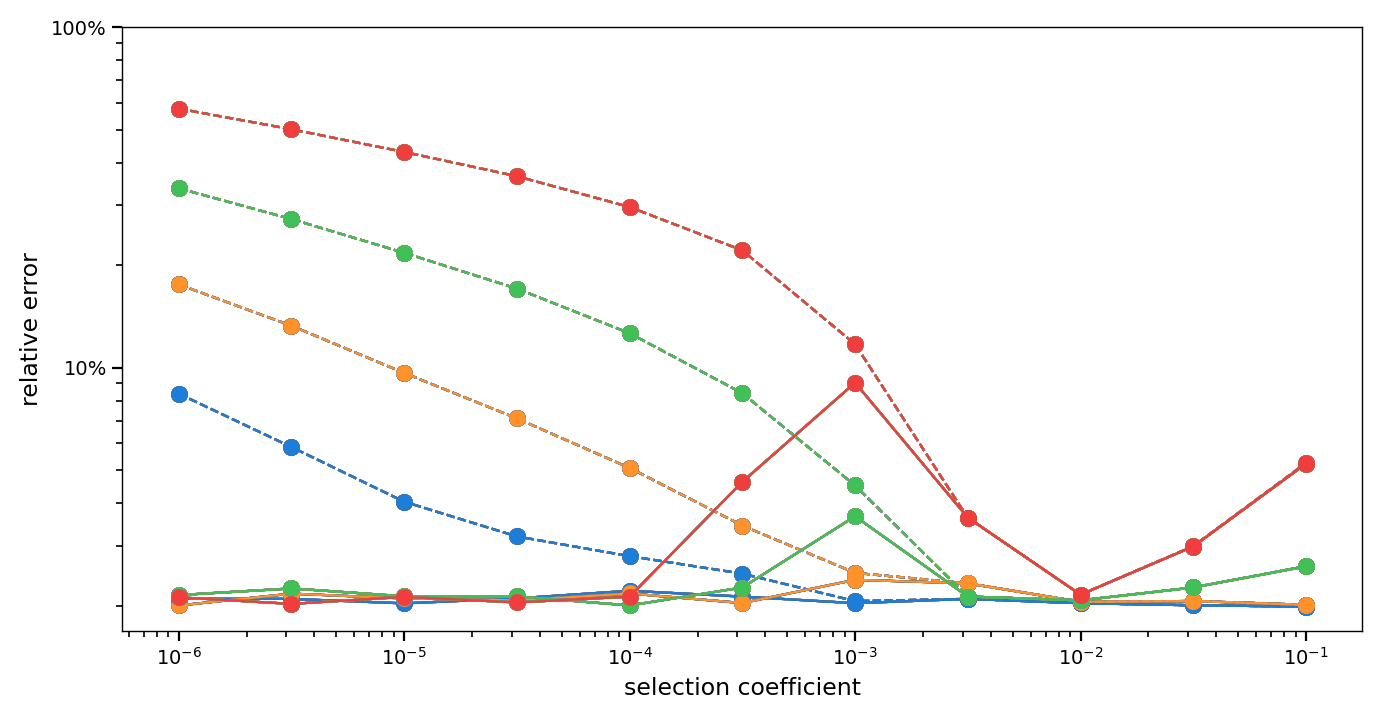

In [227]:
rel_error_plot(mse_df)

(0.0015, 100)


/tmp/ipykernel_45685/529444394.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)
/tmp/ipykernel_45685/529444394.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(('10%', '100%'))


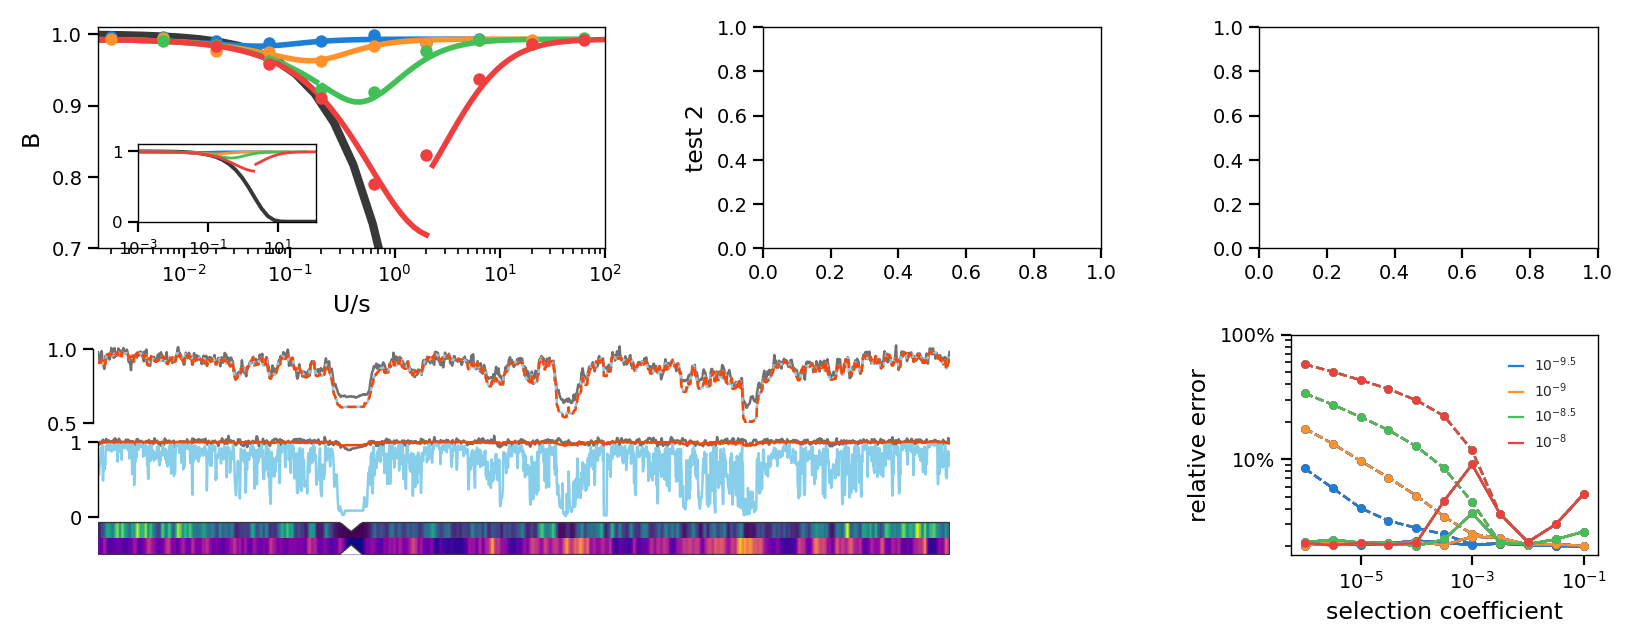

/tmp/ipykernel_53111/3848576307.py:23: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../manuscript/figures/experimental_1.pdf', bbox_inches='tight')


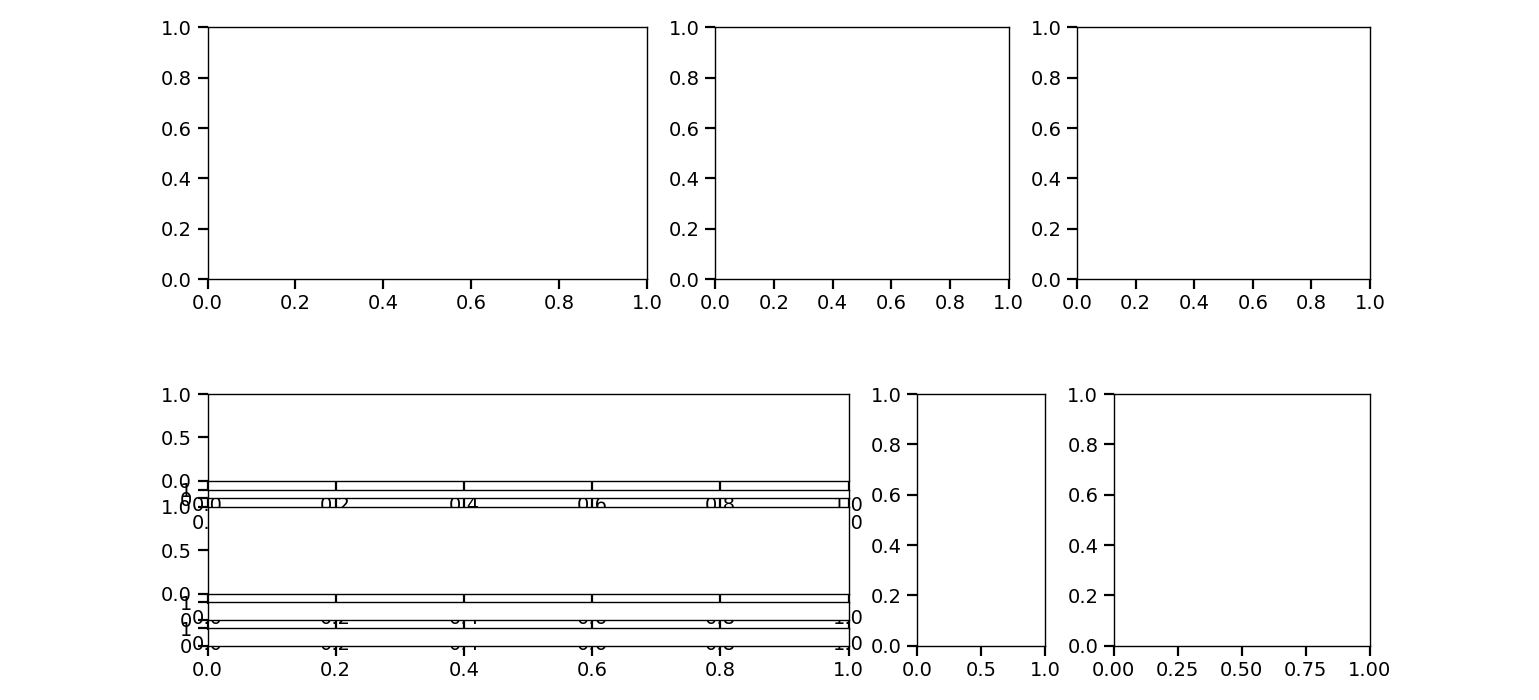

In [116]:
fig = plt.figure(constrained_layout=True, figsize=(7.5, 3.5))
subfigs = fig.subfigures(nrows=3, ncols=1, height_ratios=[1, 0.1, 1])

top_row = subfigs[0].subplots(nrows=1, ncols=3,
                              gridspec_kw={'width_ratios': [3, 2, 2], 
                                           })



mosaic = """
AFG
BFG
CFG
DFG
EFG
"""

bottom_row = subfigs[2].subplot_mosaic(mosaic,
                                       gridspec_kw={'width_ratios': [5, 1, 2], 
                                                    'height_ratios': [1, 0.1, 1, 0.2, 0.2], 
                                                    })

plt.savefig('../manuscript/figures/experimental_1.pdf', bbox_inches='tight')

In [65]:
#top_row = subfigs[0].subplots(1, 4, width_ratios=[1.2, 1, 1, 0.01])
top_row = subfigs[0].subplots(1, 3, width_ratios=[1.3, 1, 1], gridspec_kw={'wspace': 0.4, 'bottom': 0.1})
mosaic = """
AF
BF
CF
DF
EF
"""
bottom_row = subfigs[2].subplot_mosaic(mosaic)

{'A': <AxesSubplot: label='A'>,
 'F': <AxesSubplot: label='F'>,
 'B': <AxesSubplot: label='B'>,
 'C': <AxesSubplot: label='C'>,
 'D': <AxesSubplot: label='D'>,
 'E': <AxesSubplot: label='E'>}

# Miscellaenous Checks

Here are some additional visual / EDA checks of theory equations, e.g. $Q$ and a look at how the adjusted $N_e$ differs from the asymptotic $N_e$.

## Validation of $Q$ Equations

There are two classes of equations for $Q$, the selection multiplier. In both cases, $Q^2$ is used in the fomrula.

 - *Regional $Q$*: this is the multiplier effect for a single neutral locus in the middle of a segment. This is used to pre-compute the segment $V$ and $R$.
 
 - *Recombination $Q$*: this is the multiplier effect for a single segment (which is the same as a single site, with $V_m$ and $V$ adjusted accordingly, $r$ recombination fraction away.

Pre-computation of the integrated $Q$ in the main code uses the integral approximation (in code as `Q2_sum_integral()`) so we compare that against alternatives below.

/home/vsb/projects/bprime/bgspy/theory2.py:176: RuntimeWarning: overflow encountered in double_scalars
  (-1 + np.exp(((-(k*(M-2)) + M)*T)/2.))**2)/
/home/vsb/projects/bprime/bgspy/theory2.py:172: RuntimeWarning: overflow encountered in double_scalars
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:172: RuntimeWarning: overflow encountered in exp
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:172: RuntimeWarning: invalid value encountered in double_scalars
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:175: RuntimeWarning: invalid value encountered in double_scalars
  ((-2*np.exp(k*(M-2)*T - M*T) *
/home/vsb/projects/bprime/bgspy/theory2.py:176: RuntimeWarning: overflow encountered in exp
  (-1 + np.exp(((-(k*(M-2)) + M)*T)/2.))**2)/
/home/vsb/projects/bprime/bgspy/theory2.py:172: RuntimeWarning: overflow encountered in expm1
  in

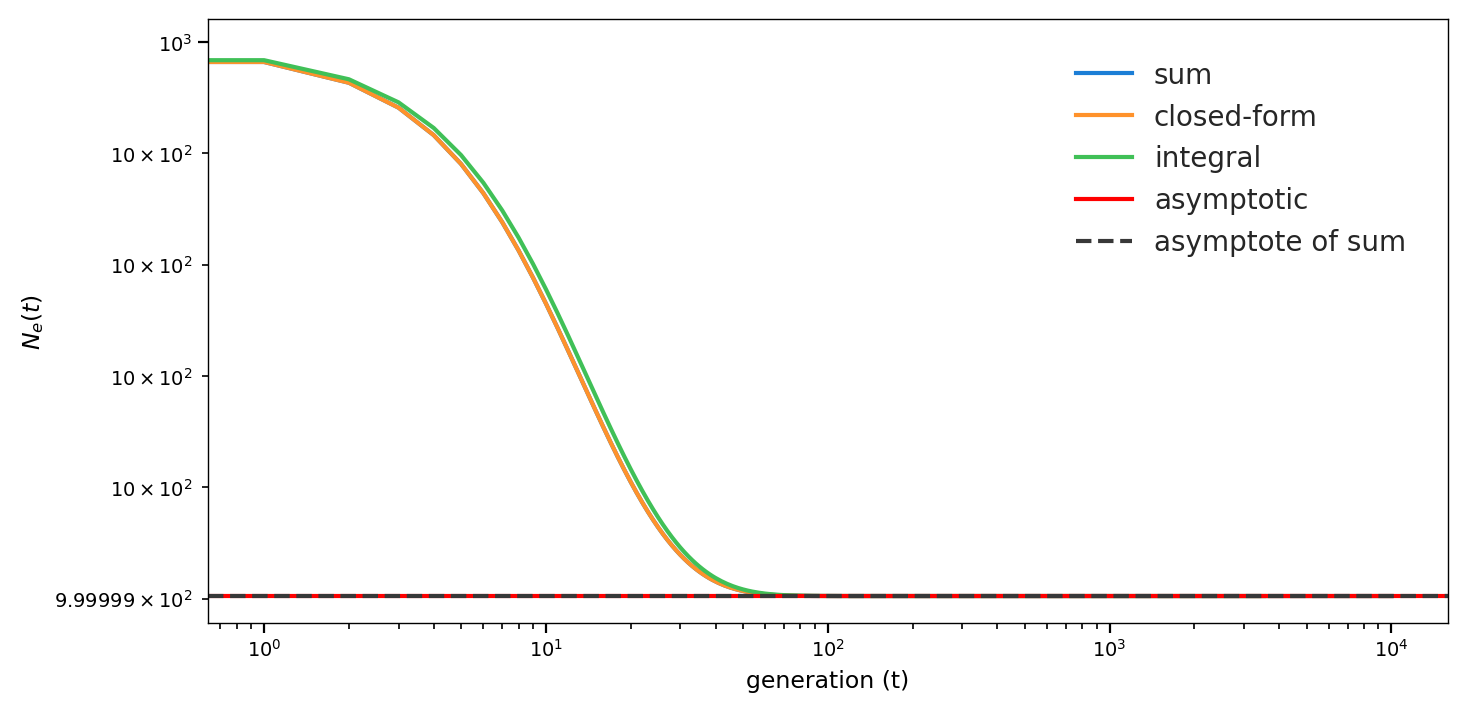

In [31]:
# some test parameters
V = 1e-8
Vm = 0.1*V
R = rbp*L
Z = 1-Vm/V
plt.plot(N*np.exp(-V/2*Q2_sum_integral(Z, R, 10000, use_sum=True)), label='sum')
plt.plot(N*np.exp(-V/2*Q2_sum_integral(Z, R, 10000, use_sum=False)), label='closed-form')
plt.plot(N*np.exp(-V/2*Q2_sum_integral2(Z, R, 10000)), label='integral')
plt.axhline(N*np.exp(-V/2 * Q2_asymptotic(Z, R)), c='r', label='asymptotic')
plt.axhline(N*np.exp(-V/2* Q2_sum_integral(Z, R)[-1]), c='0.22', label='asymptote of sum', linestyle='dashed')
plt.loglog()
plt.ylabel("$N_e(t)$")
plt.xlabel("generation (t)")
plt.legend()

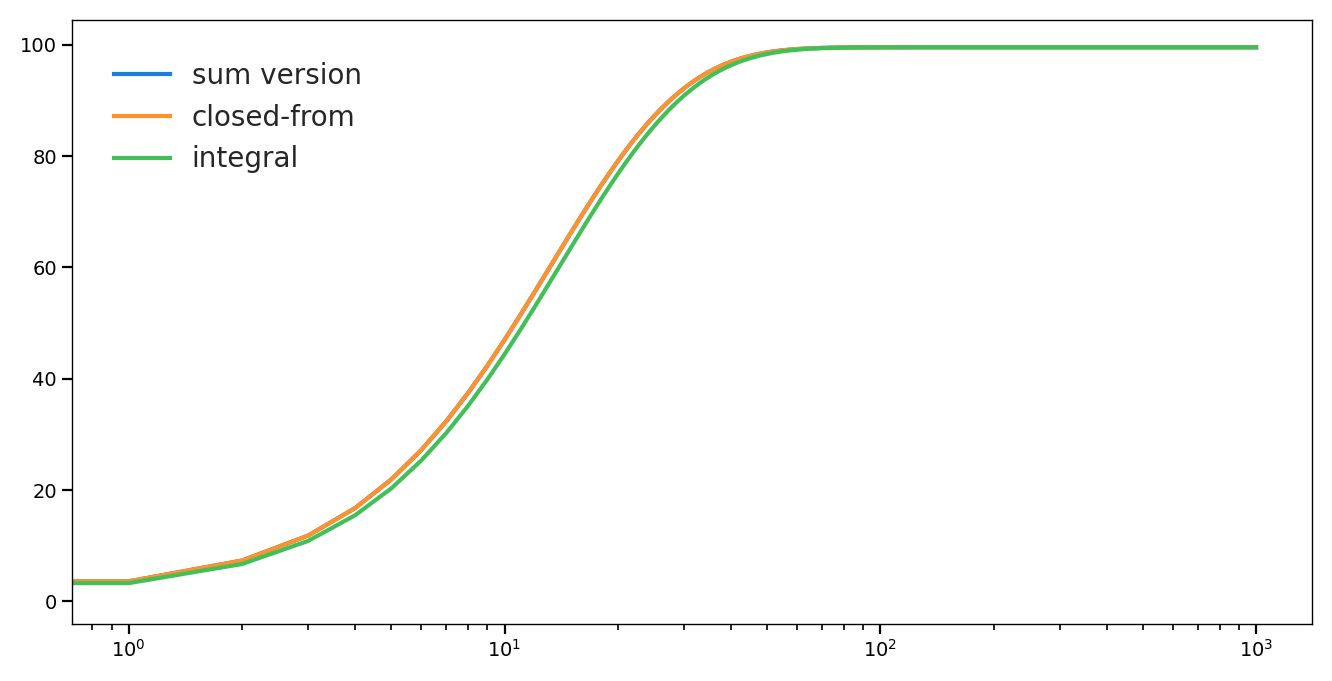

In [32]:
plt.plot(Q2_sum_integral(Z, R, use_sum=True), label='sum version')
plt.plot(Q2_sum_integral(Z, R, use_sum=False), label='closed-from')
plt.plot(Q2_sum_integral2(Z, R), label='integral')
#plt.axline((0, 0), slope=1, c='r', linestyle='dashed')
plt.semilogx()
plt.legend()

## Averaged $N_e$ vs Asymptotic $N_e$ Approximations

We pre-compute the $V$ and $V_m$ for each segment using the regional calculations. Then, we use these $V$ and $V_m$ values in a non-regional equation (just $r$), e.g. 

$$
Q(t) = \sum_{i=0}^t a^i
$$

where $a = (1-r)(1-V_m/V)$. 

Then, $N_e(t) = N \exp(-V/2 Q(t)^2$ and the $B$ estimate is 

$$
2N B = \sum_{t = 0}^\infty \prod_{i=0}^t \left(1- \frac{1}{2N_e(t)}\right)
$$

This sum takes many elements to converge. Ben Good had a [very helpful trick on Twitter](https://twitter.com/benjaminhgood/status/1588531110853881856), which reduced the number of iterations a few orders of magnitude. Still, though, this was too slow to apply each iteration so I use a linear interpolator of the "bias" between the asymptotic $N_{e,\infty}$ and $N_e(t)$.

NOTE: this turned out to matter a lot in the regional simulations (which have a large mutational target size and tight linkage), but very little in the human B maps.

In [33]:
# some example Qs -- should be very close after 100k gens
Qr_fixed(100_000, 1e-8, 1e-9, 1e-3), Qr_asymp(1e-8, 1e-9, 1e-3)

(9.910802775024777, 9.910802775024777)

How does the asymptotic $N_e$ differ from $N_e(t)$?

Note: $Q(t)$ only depends on a compound parameter $a = (1-r)(1-\kappa)$, where $\kappa = V_m/V$. So these can be combined (the functions with this alternate simpler parameteriztion of $V$ and $a$ have names that end in 2.

In [34]:
# some params
a = np.sort(1-np.logspace(-8, -1, 100))
Vs = np.logspace(-10, -7, 4)

Are the C and Python versions of the $N_e(t)$ giving us the same answers?

In [35]:
python = Ne_t_full2(N, Vs.mean(), a)

In [36]:
C = Ne_t(a, Vs.mean(), N)

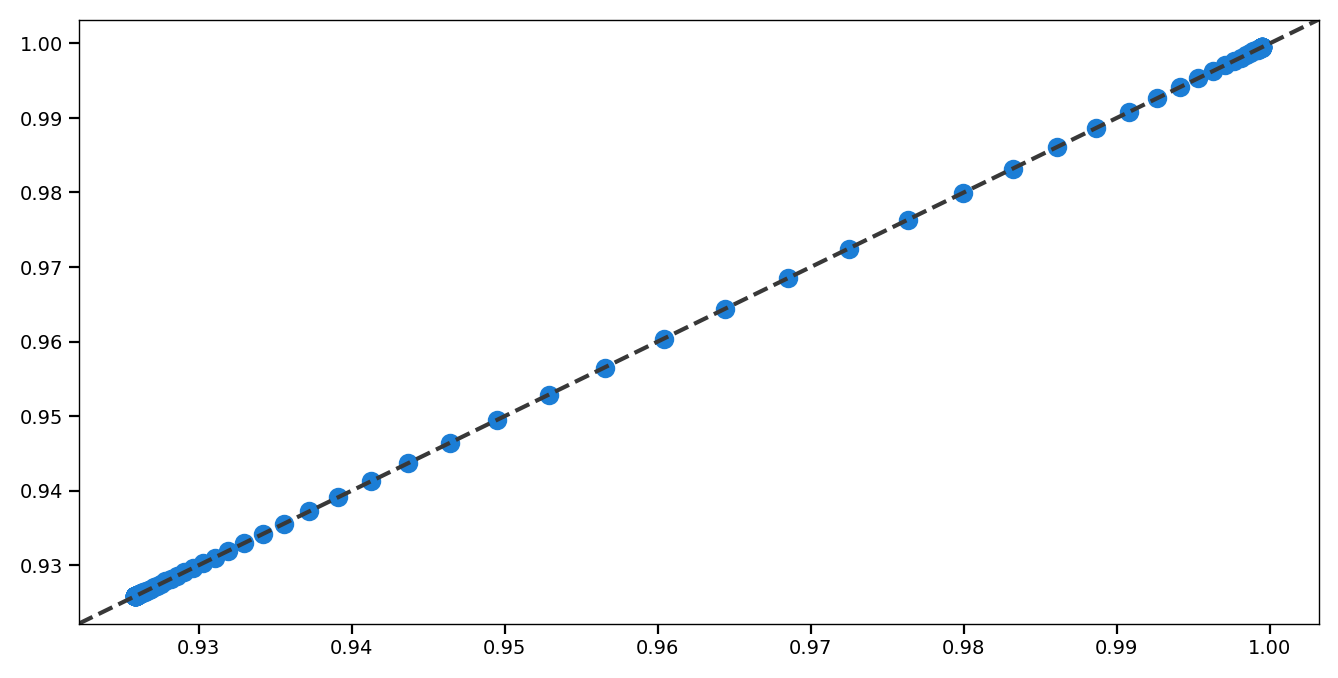

In [37]:
plt.scatter(python/N, C/N)
plt.axline((0.99, 0.99), slope=1, c='0.22', linestyle='dashed')

## Bias caused by using Asymptotic $N_e$

How big is the difference between asymptotic $N_e$ and $N_e(t)$? It causes a sort of bias, which we estimate below.

In [38]:
# a simple grid of test parameter values values
grid = np.meshgrid(a, Vs)

In [39]:
asymp = Ne_asymp2(*grid, N)/N
real = Ne_t(*grid, N)/N
bias = asymp - real 

How does B differ when asymptotic vs adjusted $N_e$ is used?

[]

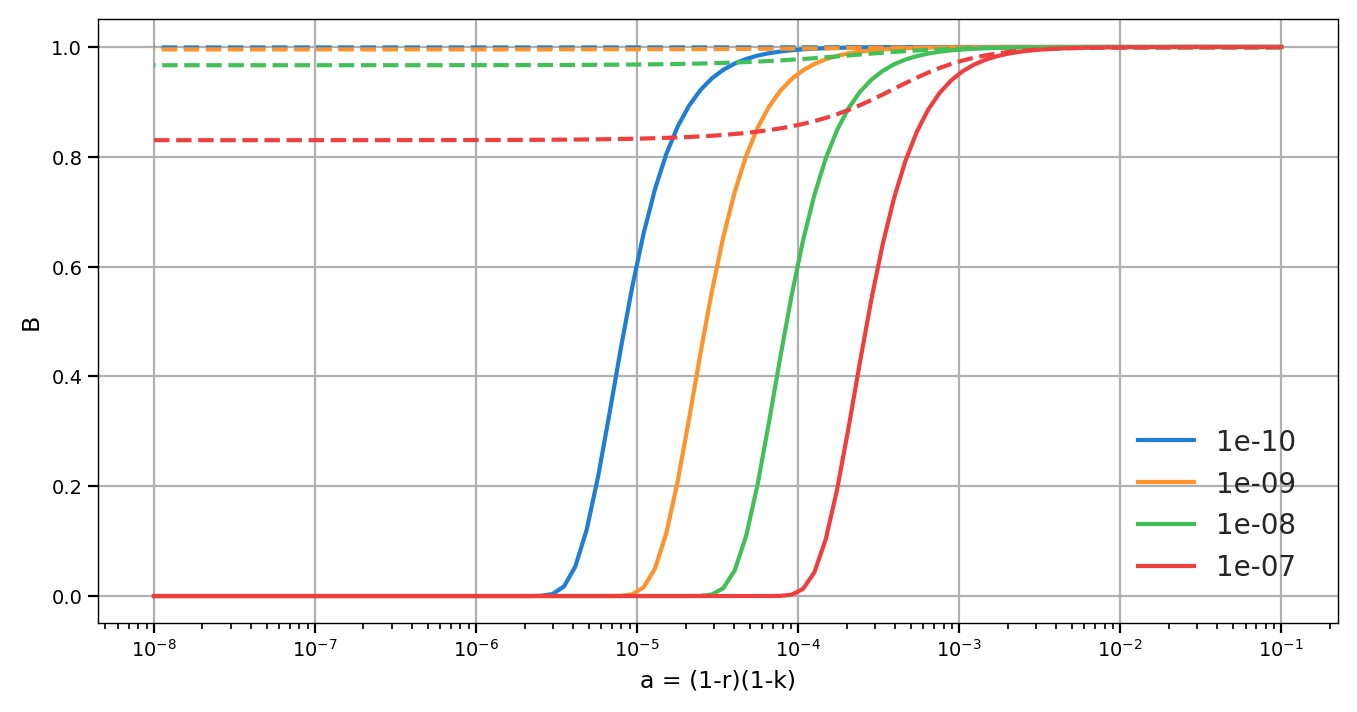

In [40]:
plt.plot(1-a, asymp.T, label=Vs)
plt.gca().set_prop_cycle(None)
plt.plot(1-a, real.T,  linestyle='dashed')
plt.grid()
plt.ylabel("B")
plt.xlabel("a = (1-r)(1-k)")
plt.legend()
plt.semilogx()

This shows why the B maps don't really need the adjusted $N_e$ — the bias is small except for very tiny a values.

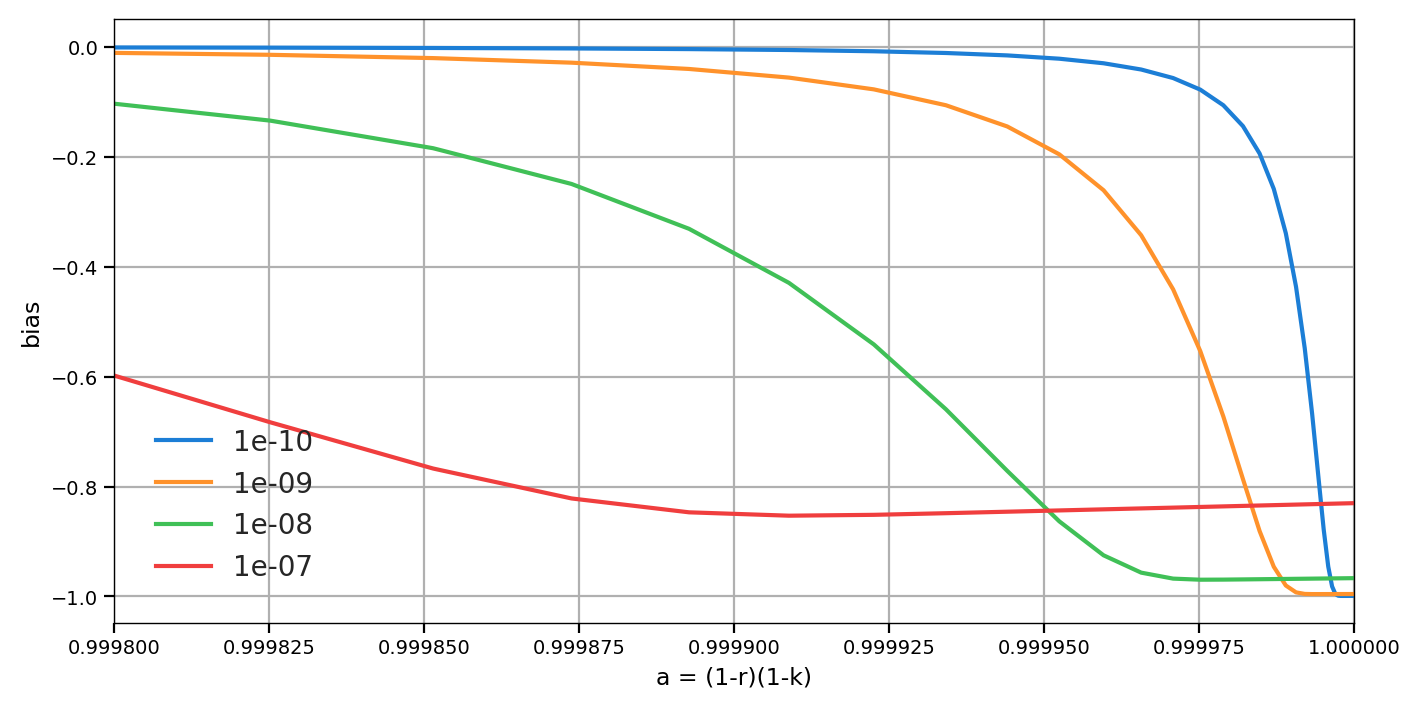

In [41]:
plt.plot(a, bias.T, label=Vs)
plt.ylabel("bias")
plt.xlabel("a = (1-r)(1-k)")
plt.legend()
plt.xlim(0.9998, 1)
plt.grid()

Note the bias is really only in the region of $a = 1-\varepsilon$ as $\varepsilon \to \infty$. This is the tight linkage / HRI region.

### Bias Interpolator 

The adjusted $N_e$ sum is incredibly slow to calculate, even with tricks, and even when implemented in C. To test whether the B maps are impacted by this, I used a grid interpolator for the bias.

Let's build an bias interpolator. There are two options in scipy, `interpn()` and `RegularGridInterpolator()`

NOTE: As mentioned elsewhere, it made little difference; the code is now commented out in the library.

In [42]:
# big grid
n = 50
a_grid = np.sort(1-np.logspace(-8, -3, n))
V_grid = np.logspace(-10, -7, n)
interp_grid = np.meshgrid(a_grid, V_grid)

In [43]:
interp_asymp = Ne_asymp2(*interp_grid, N)/N
interp_real = Ne_t(*interp_grid, N)/N
interp_bias = interp_asymp - interp_real 

In [44]:
a_grid.min(), a_grid.max()

(0.999, 0.99999999)

In [45]:
Ne_asymp2(0.9999997404975789, 1e-10, 1000)

array(0)

In [46]:
fun = RegularGridInterpolator((a_grid, V_grid), np.log10(-interp_bias).T, method='linear')

/tmp/ipykernel_45685/2484665850.py:1: RuntimeWarning: invalid value encountered in log10
  fun = RegularGridInterpolator((a_grid, V_grid), np.log10(-interp_bias).T, method='linear')


In [47]:
%%timeit

ra, rV = np.random.uniform(a_grid.min(), a_grid.max()), np.random.uniform(V_grid.min(), V_grid.max())
interpn((a_grid, V_grid), interp_bias.T, (ra, rV), method='splinef2d')

264 µs ± 997 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [48]:
%%timeit

ra, rV = np.random.uniform(a_grid.min(), a_grid.max()), np.random.uniform(V_grid.min(), V_grid.max())
fun((ra, rV))

130 µs ± 7.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [49]:
%%timeit

ra, rV = np.random.uniform(a_grid.min(), a_grid.max()), np.random.uniform(V_grid.min(), V_grid.max())
fun((ra, rV))

125 µs ± 4.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [50]:
linear = []
spline = []
reggrid = []
for i in range(1000):
    ra, rV = np.random.uniform(a_grid.min(), a_grid.max()), np.random.uniform(V_grid.min(), V_grid.max())
    linear.append(interpn((a_grid, V_grid), interp_bias.T, (ra, rV), method='linear'))
    spline.append(interpn((a_grid, V_grid), interp_bias.T, (ra, rV), method='splinef2d'))
    reggrid.append(10**fun((ra, rV)))

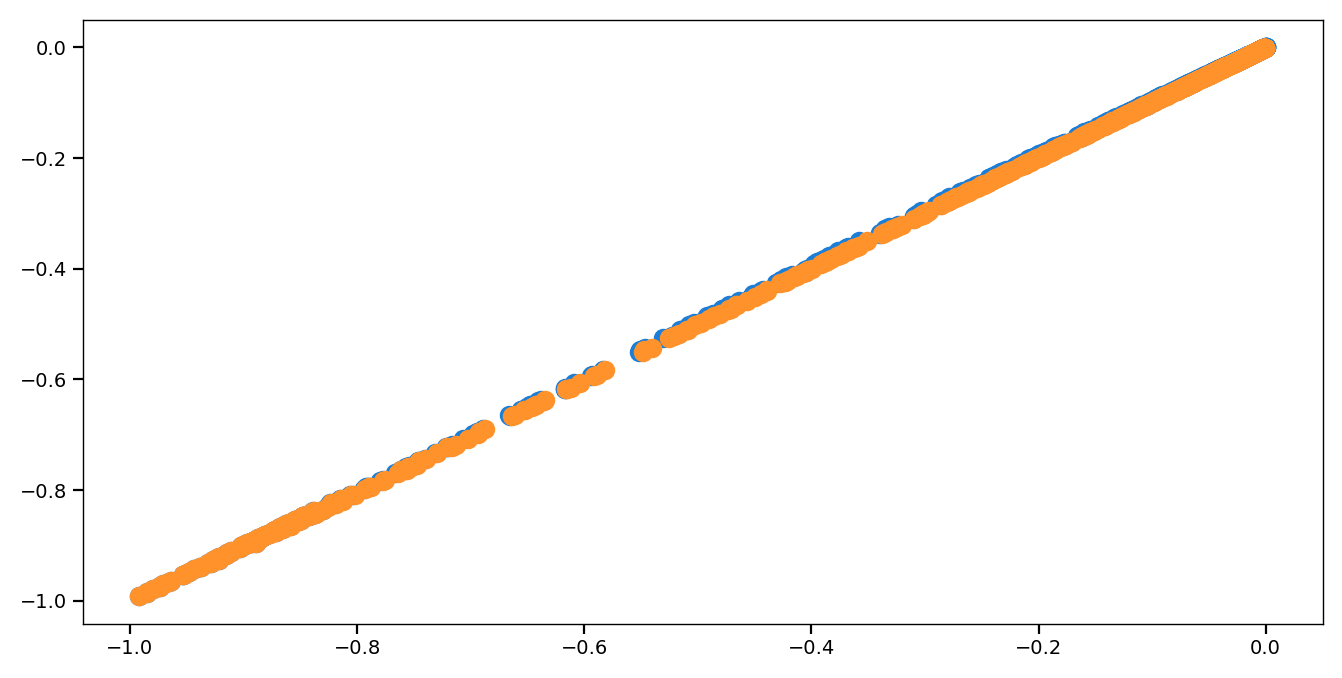

In [51]:
plt.scatter(linear, spline)
plt.scatter(-np.array(reggrid), spline)

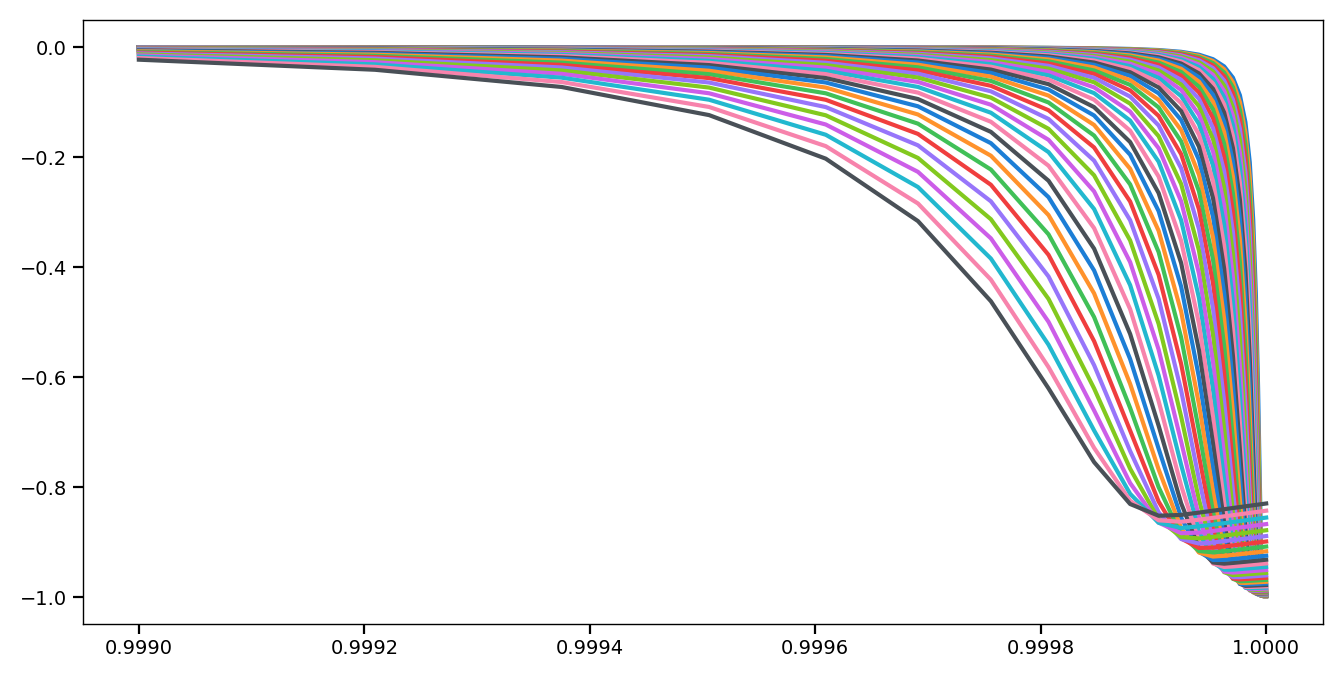

In [52]:
_ =plt.plot(a_grid, interp_bias.T,)